# Apply AI Superresolution to video - Train New Network from Video Frames

## Use a perception loss
https://github.com/richzhang/PerceptualSimilarity

 

# Get a video dataset to do better training
- higher resolution than used in research

### super 8 look https://www.youtube.com/watch?v=7Q5UZmwxIXo
- low focus (diffusion and blur - bokah)
- low contrast
- camera is more shakey on home movies
- high depth of field everything is sharp
- 4x3
- film grain
- color changes
- mpeg2 compression noise

### VCR look
- jitter on scan lines - see http://www.avisynth.nl/users/vcmohan/DeJitter/DeJitter.htm
- chroma issues https://forum.videohelp.com/threads/397928-Imrpove-old-video-recorded-by-a-bad-camera?s=0a1230911434e7442d05b6b6cee8e6d2

- jpeg compression artifacts

## use images of related material to train superres
- family photos to train for family videos
- need water and outdoors
- use video samples for video
- use film examples for super8

## Data Augmentation
- sample a few frames from a few places - complete
- different blur levels- complete
- different blur levels in the same image - complete
- convolution with disk - complete
- left-right flip - complete
- contrast and brightness - complete
- random crop - use center crop
- crop to the super8 resolution 720x480 or video 320x240 - complete
- GAN statistics
- predict level of blur with same network to encourage differentiation to that
- input of a filter that detects light reflections to help infer blurring
- try mixup
- use a single shot classifier output as an input

- see this library for blending images https://pypi.org/project/blend-modes/


## Optimization
- Use Adam - complete
- Use optimal learning rate
- freeze layers
- dropout
- use fp16 - pytorch1.6 has a new library for this - complete
- train on low res and increase resolution - does not seem to help in convergence

## losses
- try l1 loss - does not converge
- try perceptive loss vgg18 - complete
- perceptive loss uses 256x256 images - too low res, so use overlapping subsets of image to calc loss
- combine perceptive and mse loss
- calculate mse loss on a smoothed version of output compared to input (which is smoothed) - ensure reversal matches


## do comparisons for standard test sets
- not super useful since they use gaussian blurring, bicubic interpolation
- get very focused images and use as a validation and test set - prefer one thats published


## Results & Analysis
- Fixes - jpeg artifacts were fixed at one level 30 and slope at 0.01 in:
Superresolution train vdsr with multifuz
Superresolution train vdsr with perception loss multifuz

- mse only goes so far.  too strict
- Perceptual loss helps improve it, but input is 256x256 resolution so limited sharpness.
- Perceptual loss tiled (hires) causes too much causes artifacts
- multifuz improves results especially with perceptual loss, handles different fuzziness better

Next experiment
- training may not need to go as long - complete
- set kernel range from 1 to 20 - vs 4-20 need lower range too - complete
- combination of hi res perceptual and mse on smoothed versions of input.- complete
- give more emphasis to mse

Other ideas
- train on cleaner images div8K
- cascade 2 models.  Train first as usual.  Use it to preprocess input to train second model
- apply mix-up
- better model and apply to all 3 colors - tried, but no improvement.
- try vgg perception metric
- focus prediction


RCAN Results
- Uses lots of resources as scale of image increases
- Does not handle different scales well
- not meant for restoration - 
To try
- Apply pretrained model on a patch thats 48x48 then can judge if its worth making an approach to apply repeatedly to larger images.
- train vdsr with a convolutional upscaling up front, attention, residuals.

UNET results
- Some sharpening but not drastic.  Not better than VDSR
- Used 2x GPU mem than VDSR

New Network results
- Performs as well as VDSR qualitatively, need to check.
- using Div2K gives better results (needs low learning rate)
- try with L1 norm (less noise sensitive)
- add upscale in the middle to allow more flexibility - nn.ConvTranspose2d(in_channels=C, out_channels=M, kernel_size=5, stride=2, padding=2, output_padding=1, bias=False)
- add  with torch.no_grad():  to validation and prediction with the model to speed up computations.


To Try
- UNET or VDSR with MAXout nonlinear function.  Try different activation functions (mish,etc).
- consistency error measure like fastai superres
- provide input,target  pairs with no fuzziness in the training set.
- Train exclusively on very sharp  images (DIV2K)
- Predict focus as a segmentation in addition to enhancing
- have 3 channel inputs (RGB or ??) and then have 1 channel output
- provide frame-1,frame,frame+1 to predict frame
- opposite of bottleneck - input resolution -> high res -> input res blocks.
- combo of UNET and VDSR
- attention?
- combo of perception and mse measure
- add validation set
- sort dataset into hard cases and easy cases, making cases harder with time.  (train on easy cases first, then fine tune with harder cases)
- make the camera model version of the data loader
- use mse but give more error to perception
- try reflection padding







## Share results
- put out an example on youtube to allow comparison


# Project Documentation

In [1]:

from pathlib import Path
import os


project_base = "/media/SSD/superres/"
results_folder = "Results"
data_folder = "video_data"
model_folder = "checkpoint"

model_name_base = "NEWCNN2"


## Experiment documentation

In [2]:
%%javascript
var nb = IPython.notebook;
var kernel = IPython.notebook.kernel;
var command = "NOTEBOOK_FULL_PATH = '" + nb.base_url + nb.notebook_path + "'";
kernel.execute(command);

<IPython.core.display.Javascript object>

In [3]:
print("NOTEBOOK_FULL_PATH:\n", NOTEBOOK_FULL_PATH)

NOTEBOOK_FULL_PATH:
 /SSD_link/superres/Superresolution train New Network Div2 training.ipynb


In [4]:
nb_path = Path(NOTEBOOK_FULL_PATH)
print(nb_path)

# Make result folder if it does not exist
result_path = Path(project_base, results_folder , nb_path.stem )
print(result_path)
os.makedirs(result_path, exist_ok=True)

/SSD_link/superres/Superresolution train New Network Div2 training.ipynb
/media/SSD/superres/Results/Superresolution train New Network Div2 training


In [5]:
model_out_path=Path(project_base)/model_folder
print(model_out_path)
os.makedirs(model_out_path, exist_ok=True)

/media/SSD/superres/checkpoint


In [6]:
# Tie a result to a set of params.  Tie a set of params to a model.  Tie a model to a notebook.
# register the experiment to get a unique run id
# save all the results in a repository
# use github to do it?

In [7]:

#%reload_ext autoreload
#%autoreload 2
#%matplotlib inline


import cv2 
import numpy as np
import subprocess as sp
import time
from tqdm import tqdm, trange
import torch
from torch.autograd import Variable
import torch.backends.cudnn as cudnn
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

from torchvision.transforms import RandomHorizontalFlip,ColorJitter
from torchvision.transforms import Compose, CenterCrop, ToTensor, Resize, Grayscale,ToPILImage

import random
#from astropy.convolution import  Gaussian2DKernel, Tophat2DKernel,AiryDisk2DKernel


#import sys
#sys.path.insert(0, '/media/SSD/superres/pytorch-vdsr/')

#from vdsr import Net

import lpips #https://github.com/richzhang/PerceptualSimilarity

In [8]:
import torch.utils.data as data

from os import listdir
from os.path import join
from PIL import Image, ImageFilter
import numpy as np
import torchvision as vision

import numbers


torch.cuda.manual_seed(42)

Create a data loader
- see https://github.com/2KangHo/vdsr_pytorch/blob/master/data.py
- see https://github.com/2KangHo/vdsr_pytorch/blob/master/data_utils.py

In [9]:
import fnmatch

In [10]:
def is_image_file(filename):
    return any(filename.endswith(extension) for extension in [".png", ".jpg", ".jpeg", ".bmp"])

def is_video_file(path, extensions = ("mp4",)):
    return path.lower().endswith(extensions)

def frame_sampler1(length, frame_sample_size):

    # calculate middle of video and take 'frame_sample_size' frames from middle
    middle = length // 2
    left_length = frame_sample_size//2
    right_length = frame_sample_size - left_length
    left = max(0,middle - left_length)
    right = min(length, middle + right_length)
          
    return list(range(left,right))



def frame_sampler2(length, frame_sample_size):
    return np.linspace(0, length, 3+min(frame_sample_size,length)).astype(int)[2:-1]


# Make this load still photos too, and have them added with frame = 0
def make_framelist(video_dir,frame_sample_size = 10, match_exp = "*.*"):
    instances = []
    for filename in listdir(video_dir):
        

        if fnmatch.fnmatch(filename, match_exp):
            filepath = os.path.join(video_dir,filename)
            #print(filename)

            if is_video_file(filepath):
                # open video file
                cap = cv2.VideoCapture(str(filepath))

                # get frame count
                length = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

                cap.release()

                if frame_sample_size is not None:
                    samples = frame_sampler2(length, frame_sample_size)
                    # append fn and frame num to instances
                else:
                    samples = range(0,length)

                for frame in samples:
                    item = {"Filepath":filepath,"Type":"frame",  "Framenum":frame}
                    instances.append(item)

            elif is_image_file(filepath):
                # open image file
                img = cv2.imread(filepath)
                item = {"Filepath":filepath, "Type":"image"}
                instances.append(item)
            
    return instances
        

In [11]:
# get a list of all the data
instances = make_framelist("/home/filip/SSD_link/superres/DIV2K/DIV2K_train_HR",1)

In [12]:
instances

[{'Filepath': '/home/filip/SSD_link/superres/DIV2K/DIV2K_train_HR/0185.png',
  'Type': 'image'},
 {'Filepath': '/home/filip/SSD_link/superres/DIV2K/DIV2K_train_HR/0054.png',
  'Type': 'image'},
 {'Filepath': '/home/filip/SSD_link/superres/DIV2K/DIV2K_train_HR/0193.png',
  'Type': 'image'},
 {'Filepath': '/home/filip/SSD_link/superres/DIV2K/DIV2K_train_HR/0687.png',
  'Type': 'image'},
 {'Filepath': '/home/filip/SSD_link/superres/DIV2K/DIV2K_train_HR/0618.png',
  'Type': 'image'},
 {'Filepath': '/home/filip/SSD_link/superres/DIV2K/DIV2K_train_HR/0019.png',
  'Type': 'image'},
 {'Filepath': '/home/filip/SSD_link/superres/DIV2K/DIV2K_train_HR/0507.png',
  'Type': 'image'},
 {'Filepath': '/home/filip/SSD_link/superres/DIV2K/DIV2K_train_HR/0330.png',
  'Type': 'image'},
 {'Filepath': '/home/filip/SSD_link/superres/DIV2K/DIV2K_train_HR/0099.png',
  'Type': 'image'},
 {'Filepath': '/home/filip/SSD_link/superres/DIV2K/DIV2K_train_HR/0619.png',
  'Type': 'image'},
 {'Filepath': '/home/filip/SSD

In [13]:
def load_frame(instance):
    
    path = instance["Filepath"]
    
    if instance["Type"] == "frame":
        
        frame = instance["Framenum"]
        cap = cv2.VideoCapture(path)
        cap.set(cv2.CAP_PROP_POS_FRAMES, frame-1)
        ret, img = cap.read()
        if ret==0:
            print("Error with:",instance)
    elif instance["Type"] == "image":
        img = cv2.imread(path)
    # convert to PIL RGB
    im_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    return Image.fromarray(im_rgb)



In [14]:
def tophat2D(r):
    
    d=2*int(r)+1
    Y, X = np.ogrid[:d, :d]
    c=int(r)
    k = (np.sqrt((X-c)**2 +  (Y-c)**2) <= r)*1 
    
    return k/k.sum()

In [15]:
class RescaleCrop(object):


    def __init__(self, crop_size ,kernel_width):
        
        if isinstance(crop_size, numbers.Number):
            self.crop_size = (int(crop_size), int(crop_size))
        else:
            self.crop_size = crop_size 
        
        self.kernel_width = kernel_width
        

    
        

    def __call__(self, img):
        
        
        # Ideal steps
        # Crop with proportional scale, to simulate images of different input resolutions (if thats a requirement)
        # This crop should leave some edges of the image to allow blurring with kernel beyond final size
        # Blur the image 
        # If different randomly picked blurring kernels are used, they should have equivalent blurring power.
        
        h_size,v_size = img.size
        
        #print("im size:", img.size)
        
        # Resize down to a size a bit larger than final size to allow proper blurring
        v_wanted = int(self.crop_size[0]+self.kernel_width+1)
        h_wanted = int(self.crop_size[1]+self.kernel_width+1)
        
        #print("im wanted:", (h_wanted, v_wanted))
        
        h_scale = h_wanted/h_size
        v_scale = v_wanted/v_size
        
        scale = max(h_scale, v_scale)
        
        #print("scales=",(h_scale, v_scale))
        
        #print("new size=",(int(h_size*scale), int(v_size*scale)))
        img = img.resize((int(h_size*scale), int(v_size*scale)))
        
        img = CenterCrop((v_wanted,h_wanted))(img) 

        
        return img

In [16]:

def cv_center_crop(img,output_size):
        if isinstance(output_size, numbers.Number):
            output_size = (int(output_size), int(output_size))
            
        
        image_height = img.shape[0]
        image_width = img.shape[1]
        
        crop_height, crop_width = output_size
        crop_top = max(0,int(round((image_height - crop_height) / 2.)))
        crop_left = max(0,int(round((image_width - crop_width) / 2.)))
        #print("input:",img.shape)
        #print("output:",output_size)
        #print("crop:",crop_top,crop_top+output_size[0],crop_left,crop_left+output_size[1])
        return img[crop_top:crop_top+output_size[0],crop_left:crop_left+output_size[1]]

In [17]:
def create_circular_mask(h, w, slope=0.01, center=None, radius=None, scale=1.0):

    if center is None: # use the middle of the image
        center = (int(w/2), int(h/2))
    if radius is None: # use the smallest distance between the center and image walls
        radius = min(center[0], center[1], w-center[0], h-center[1])

    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((scale*(X - center[0]))**2 + ((Y-center[1])/scale)**2)

    mask = np.minimum((np.maximum(dist_from_center-radius,0)*slope)**(0.5),1.0)
    return mask

In [18]:
def cv_disk_blur(img_cv, kernel_width):
    k = tophat2D(int(kernel_width)/2.0)
    return cv2.filter2D(img_cv, cv2.CV_32F, k)

In [19]:
def pil_disk_blur(img,kernel_width):
    img_cv = cv_disk_blur(np.array(img),kernel_width)
    img_cv = cv2.normalize(img_cv, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8UC1)
    return Image.fromarray(img_cv)

In [20]:
class Multifuz(object):


    def __init__(self, crop_size ,kernel_a, kernel_b, quality, slope, radius, scale, center):
        
        if isinstance(crop_size, numbers.Number):
            self.crop_size = (int(crop_size), int(crop_size))
        else:
            self.crop_size = crop_size 
        
        self.kernel_a = kernel_a
        self.kernel_b = kernel_b
        self.quality = quality.item()
        self.slope = slope
        self.radius = radius
        self.scale = scale
        self.center = center
        

    
        

    def __call__(self, img):
        
        img_cv = np.array(img)
        d = img_cv .shape
        dim = (d[1], d[0])
        height = d[0]
        width = d[1]
        color = len(d)-2
        
        
        #blur kernel A
        
        k = tophat2D(int(self.kernel_a)/2.0)
        img_cv_blurA = cv2.filter2D(img_cv, cv2.CV_32F, k)
        img_cv_blurA = cv_center_crop(img_cv_blurA,self.crop_size)
        
        #blur kernel B
        k = tophat2D(int(self.kernel_b)/2.0)
        img_cv_blurB = cv2.filter2D(img_cv, cv2.CV_32F, k)
        img_cv_blurB = cv_center_crop(img_cv_blurB,self.crop_size)
        
        #add them with a mask
        # Normalize the alpha mask to keep intensity between 0 and 1
        
        alpha = create_circular_mask(h=self.crop_size[0], w=self.crop_size[1], slope=self.slope,center=self.center,
                                     radius=self.radius, scale = self.scale)*1.0
        
        if color ==1:
            alpha=np.reshape(alpha, (self.crop_size[0],self.crop_size[1],-1))
            alpha=np.broadcast_to(alpha,[self.crop_size[0],self.crop_size[1],3])
        
        #alpha = alpha.astype(float)/255
        
        # Multiply the foreground with the alpha matte
        
        
        
        img_cv_blurA = cv2.multiply(img_cv_blurA, alpha, dtype=cv2.CV_32F )
        # Multiply the background with ( 1 - alpha )

        
        img_cv_blurB = cv2.multiply(img_cv_blurB, 1.0 - alpha, dtype=cv2.CV_32F)
        # Add the masked foreground and background.

        #img_cv = img_cv_blurA
        img_cv = cv2.add(img_cv_blurA, img_cv_blurB, dtype=cv2.CV_32F)
        
        img_cv = cv2.normalize(img_cv, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8UC1)
        
        
        
    
        #Center Crop
        #img_cv = cv_center_crop(img_cv,self.crop_size)
        
        #Jpeg compression (for adding artifacts)
        
        is_success, im_buf_arr = cv2.imencode(".jpg", img_cv,params = [cv2.IMWRITE_JPEG_QUALITY,self.quality])
        
        
        img_cv = cv2.imdecode(im_buf_arr,flags=cv2.IMREAD_COLOR)
        
        
        img= Image.fromarray(img_cv)
        return img

(731, 491) (720, 480)


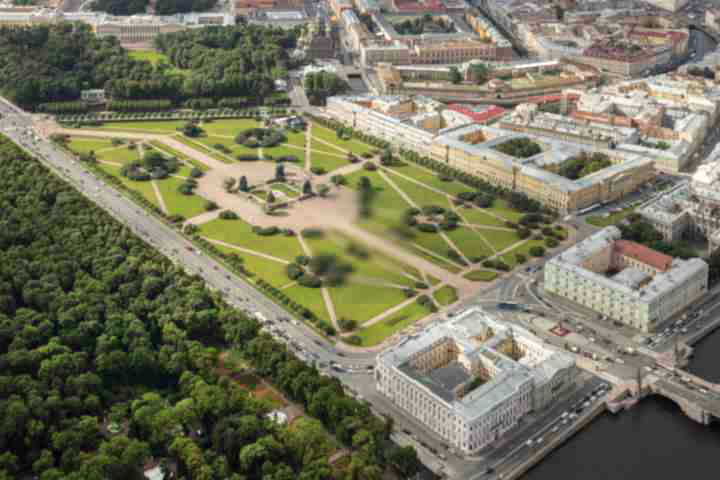

In [21]:
#test the Multifuz transform
im=load_frame(instances[10])
#im = Grayscale(num_output_channels=1)(im)
im = RescaleCrop(crop_size=(480,720),kernel_width=10)(im)
im_res = Multifuz(crop_size = (480,720),
                  center=(360,240),
                  kernel_a=2, 
                  kernel_b=10,
                  quality=np.int16(22), 
                  slope=.1,
                 radius=50,
                 scale=1)(im)
print(im.size,im_res.size)
type(im_res)
im_res

In [22]:
class DatasetFromVideoFolder(data.Dataset):
    def __init__(self, video_dir,crop_size,frame_sample_size=10,max_kernel=10,Flip_hor=True,
                 Rand_bright_contrast=True, target_transform=None, match_exp="*.*", **camera_params):
        
        #  add_noise=None, noise_std=3.0, Flip_hor=False,Rand_bright_contrast=False, kernel_width=10

        super(DatasetFromVideoFolder, self).__init__()
        self.video_frames = make_framelist(video_dir,frame_sample_size,match_exp)
        
        self.Flip_hor = Flip_hor
        self.Rand_bright_contrast = Rand_bright_contrast
        self.crop_size = crop_size
        self.max_kernel = max_kernel
        self.target_transform = target_transform
        self.camera_params = camera_params
        self.input_transform = input_transform
        
    def camera_transform(self,img_hr):
        
        # go through the parameters and simulate the camera
        width, height = img_hr.size
               
        crop_top = max(0,int(round((height - self.crop_size[0]) / 2.)))
        crop_bottom = crop_top + self.crop_size[0]
        crop_left = max(0,int(round((width - self.crop_size[1]) / 2.)))
        crop_right = crop_left + self.crop_size[1]
        
        camera_specs = {}
        camera_specs["crop_size"] = np.int16(self.crop_size)
        
        camera_specs["center"] = np.int16((random.uniform(crop_left, crop_right),random.uniform(crop_top, crop_bottom)))
        
        camera_specs["scale"] = np.float32(random.uniform(0.5,2))
       
        
        camera_specs["kernel_a"] = np.float32(random.uniform(*self.camera_params["kernel_range"]))
        camera_specs["kernel_b"] = np.float32(random.uniform(*self.camera_params["kernel_range"]))
        camera_specs["quality"] = np.int16(random.uniform(*self.camera_params["quality_range"]))
        camera_specs["slope"] = np.float32(random.uniform(*self.camera_params["slope_range"]))
        camera_specs["radius"] = np.float32(random.uniform(*self.camera_params["radius_range"])*max(self.crop_size[0],self.crop_size[1]))
        
        img_lr = Multifuz(**camera_specs)(img_hr)
        return img_lr, camera_specs

    def __getitem__(self, index):
        img_hr = load_frame(self.video_frames[index])
        if self.crop_size is not None:
            img_hr = RescaleCrop(self.crop_size,self.max_kernel )(img_hr)
        
        if self.Flip_hor:
            img_hr = RandomHorizontalFlip()(img_hr)
        
        if self.Rand_bright_contrast:
            img_hr = ColorJitter(brightness=.2, contrast=.2)(img_hr)
        
        

        
        # go through the parameters and simulate the camera
        img_lr,camera_specs = self.camera_transform(img_hr)
            
        
        if self.input_transform:
            img_lr = self.input_transform()(img_lr)
        
        if self.target_transform:
            img_hr = self.target_transform(img_hr)
            
        #print(camera_specs)
        return img_lr, img_hr, camera_specs

    def __len__(self):
        return len(self.video_frames)

In [23]:
def input_transform():        
    return Compose([        
        Grayscale(num_output_channels=1),
        ToTensor(),
    ])



def target_transform(crop_size):
    return Compose([
        Grayscale(num_output_channels=1),
        CenterCrop(crop_size),
        ToTensor(),
    ])


In [24]:
train_dir = "/home/filip/SSD_link/superres/DIV2K/DIV2K_train_HR"
#train_dir = "/home/filip/SSD_link/superres/video_data/train_data"
frame_sample_size =10
batch_size = 4 # Make 4 For FP16, 480x720 size images
crop_size = (480,720)
#crop_size = (256,256)
kernel_range=(3,10)
quality_range=(30,90) 
slope_range=(0.001, 0.1)
radius_range=(.25,.75)
scale_range=(1/2,2)
Flip_hor=True
Rand_bright_contrast=True

In [25]:
train_set = DatasetFromVideoFolder(train_dir,crop_size,frame_sample_size,
                                   input_transform=input_transform(),
                                   target_transform=target_transform(crop_size),
                                   Flip_hor=Flip_hor,
                                   Rand_bright_contrast=Rand_bright_contrast,
                                   kernel_range=kernel_range,
                                   quality_range=quality_range,
                                   slope_range=slope_range,
                                   radius_range=radius_range,
                                   scale_range=scale_range,
                                   max_kernel=10
                            )
training_data_loader = DataLoader(dataset=train_set, num_workers=0, batch_size=batch_size, shuffle=True)

In [26]:
valid_dir = "/home/filip/SSD_link/superres/DIV2K/DIV2K_valid_HR"
#frame_sample_size =10
#batch_size = 4 # Make 4 For FP16, 480x720 size images
#crop_size = (480,720)

kernel_range=(3,10)
quality_range=(30,99) 
slope_range=(0.001, 0.1)
radius_range=(.25,.75)
scale_range=(1/2,2)
Flip_hor=False
Rand_bright_contrast=False
match_exp = "*.*"

In [27]:
valid_set = DatasetFromVideoFolder(valid_dir,crop_size,frame_sample_size,
                                   input_transform=input_transform(),
                                   target_transform=target_transform(crop_size),
                                   Flip_hor=Flip_hor,
                                   Rand_bright_contrast=Rand_bright_contrast,
                                   kernel_range=kernel_range,
                                   quality_range=quality_range,
                                   slope_range=slope_range,
                                   radius_range=radius_range,
                                   scale_range=scale_range,
                                   max_kernel=10,
                                   match_exp=match_exp,
                            )
valid_data_loader = DataLoader(dataset=valid_set, num_workers=0, batch_size=batch_size, shuffle=False)

In [28]:
# measurement of blur of an image
def variance_of_laplacian(image):
    # compute the Laplacian of the image and then return the focus
    # measure, which is simply the variance of the Laplacian
    return cv2.Laplacian(image, cv2.CV_64F).var()


def show_batch(dataloader,size = 8):

    inputs, outputs, camera_specs = next(iter(dataloader))
    #print(inputs.shape)
    inputs = inputs.numpy().transpose((0, 2, 3, 1))
    outputs = outputs.numpy().transpose((0, 2, 3, 1))
    #print(camera_specs)
    
    #mean = np.array([0.485, 0.456, 0.406])
    #std = np.array([0.229, 0.224, 0.225])
    #inputs = inputs*std + mean
    #outputs = outputs*std + mean
    w,h = 2*size, 4*size
    fig=plt.figure(figsize=(w, h))
    columns = 2
    rows = 4
    ax=[]
    
    for i in range(0, rows):
        blur_measure_input = variance_of_laplacian((inputs[i]*255).astype(np.uint8))
        blur_measure_output = variance_of_laplacian((outputs[i]*255).astype(np.uint8))
        ax.append(fig.add_subplot(rows, columns, 2*i+1))
        ax[-1].set_title('Blur: '+str(blur_measure_input))
        plt.imshow((inputs[i]*255).astype(np.uint8),cmap='gray')
        ax.append(fig.add_subplot(rows, columns, 2*i+2))
        ax[-1].set_title('Blur: '+str(blur_measure_output))
        plt.imshow((outputs[i]*255).astype(np.uint8),cmap='gray')
    plt.show()

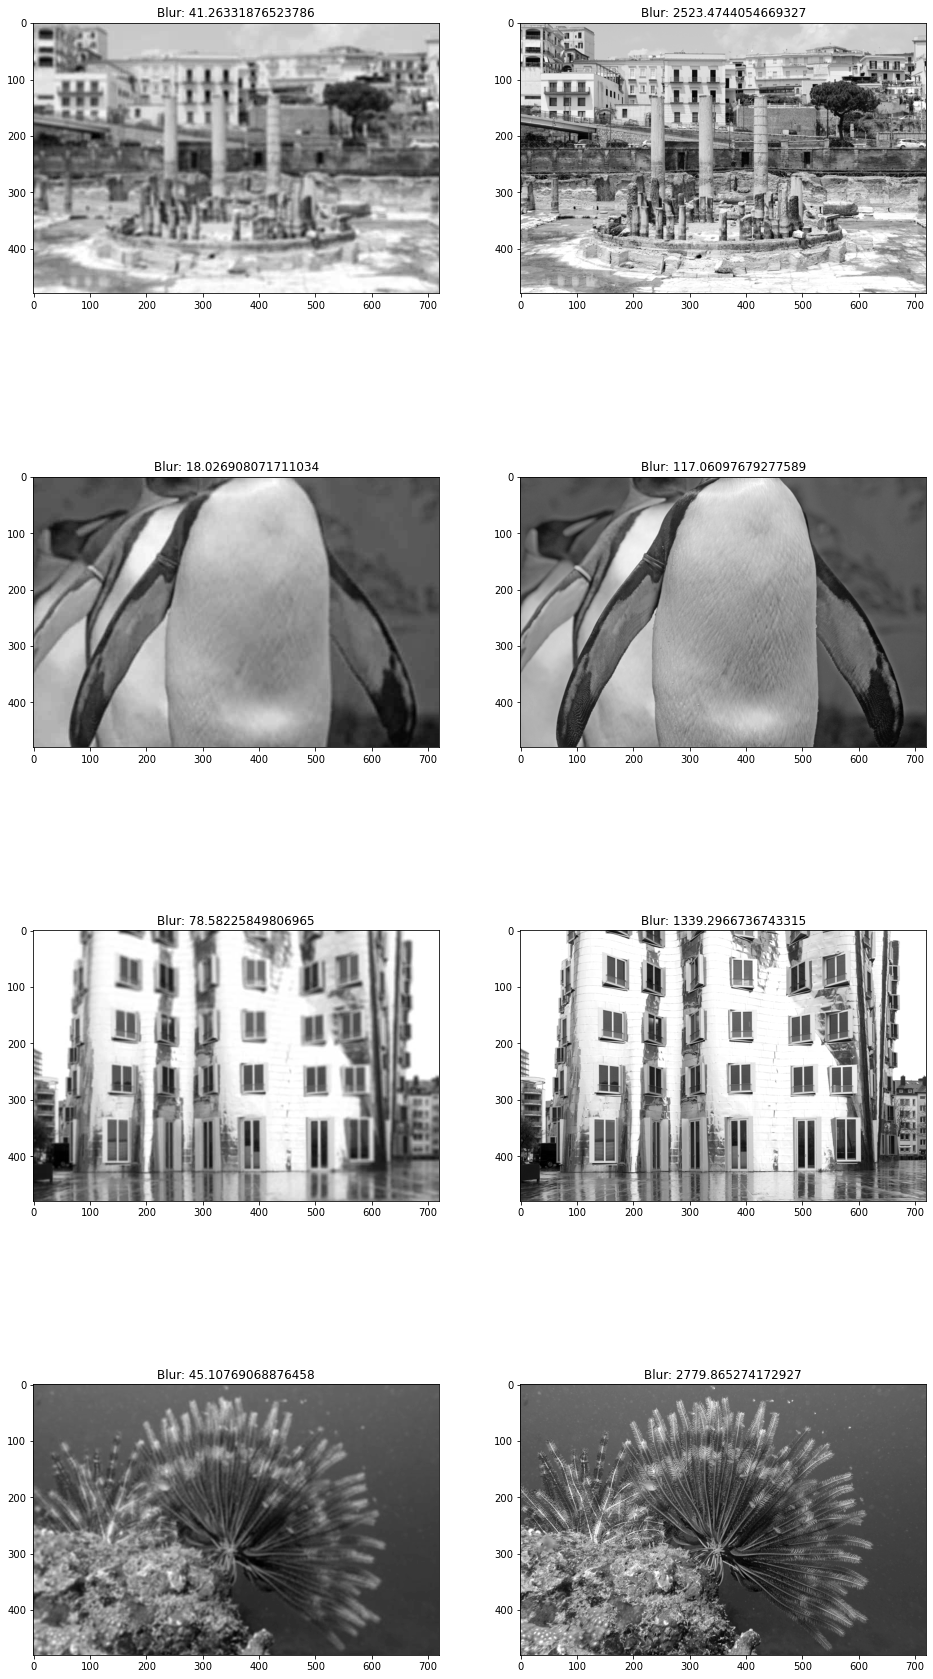

In [29]:
show_batch(training_data_loader,size =8)

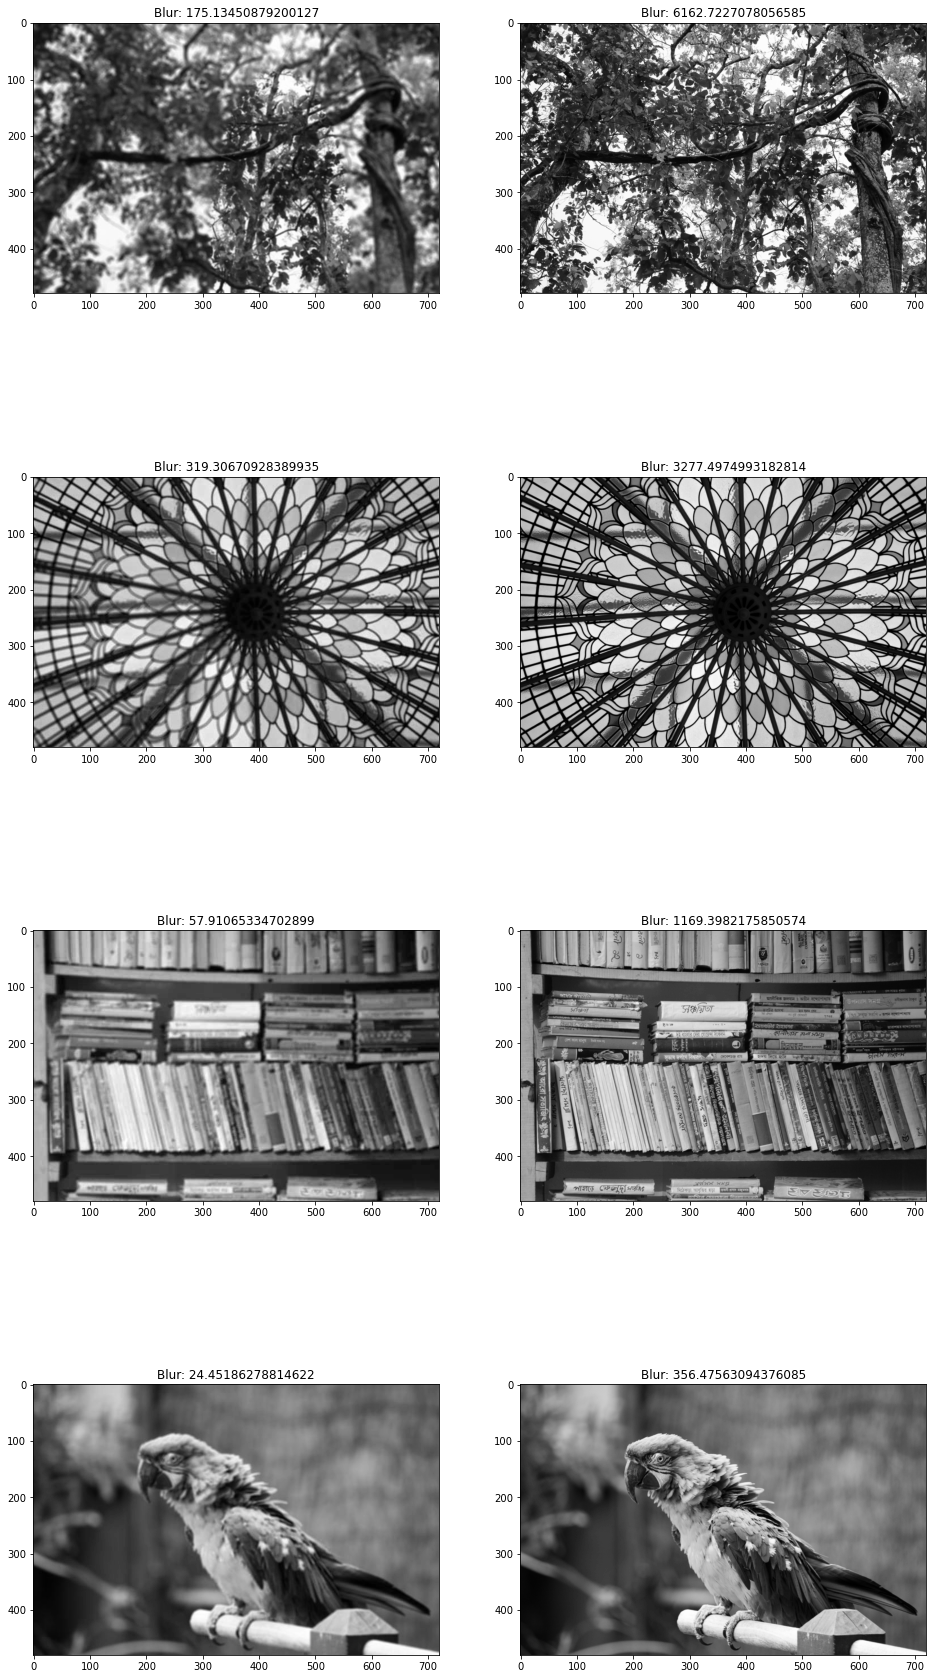

In [30]:
show_batch(valid_data_loader,size =8)

# NEW CNN

In [31]:
import torch.nn as nn

class NEWNet(nn.Module):
    def __init__(self, c1, c2):
        super(NEWNet, self).__init__()    
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=c1, kernel_size=3, stride=1, padding=1, bias=False)
        self.conv2 = nn.Conv2d(in_channels=c1, out_channels=c1, kernel_size=3, stride=1, padding=1, bias=True)
        self.conv3 = nn.Conv2d(in_channels=c1, out_channels=c1, kernel_size=3, stride=1, padding=1, bias=True)
        self.conv4 = nn.Conv2d(in_channels=c1, out_channels=c2, kernel_size=1, stride=1, padding=0, bias=True)
        self.conv5 = nn.Conv2d(in_channels=c2, out_channels=c2, kernel_size=3, stride=1, padding=1, bias=True)
        self.conv6 = nn.Conv2d(in_channels=c2, out_channels=c1, kernel_size=1, stride=1, padding=0, bias=True)
        self.convf = nn.Conv2d(in_channels=c1, out_channels=1, kernel_size=3, stride=1, padding=1, bias=True)
        self.relu = nn.ReLU(inplace=True)
        
    def forward(self, x):    
        residual = x
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.relu(self.conv3(x))
        skip1 = x
        x = self.relu(self.conv4(x))
        x = self.relu(self.conv5(x))
        x = self.conv6(x)
        x = x.add_(skip1)
        x = self.relu(x)
        x = self.convf(x)
        out = torch.add(x,residual)
        return out

# build the model

In [32]:
model = NEWNet(c1=64,c2=128)
model.cuda()

NEWNet(
  (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1))
  (conv5): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv6): Conv2d(128, 64, kernel_size=(1, 1), stride=(1, 1))
  (convf): Conv2d(64, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu): ReLU(inplace=True)
)

In [33]:
num_pixels = crop_size[0] * crop_size[1]

In [34]:
def loss_scaler(im):
    # scale to -1,1 and convert to 3 channel (greyscale to RBG)
    return (im * 2 - 1).expand(-1, 3, -1, -1)

In [35]:
class Pixel_Loss(torch.nn.Module):
    
    def __init__(self,num_pixels):
        super(Pixel_Loss,self).__init__()
        self.lossfn = nn.MSELoss(reduction = 'mean')
        
        self.percep_loss_fn = lpips.LPIPS(net='alex').cuda()


        self.num_pixels = num_pixels
    #def forward(self,x,y):
        
     #   return self.num_pixels*(self.lossfn.forward(x,y))
    
    
    def forward(self,x,y):
        
        totloss = torch.mean(self.percep_loss_fn.forward(loss_scaler(x),loss_scaler(y)))
        #print("perceptual:",totloss)
        
        totloss.add_(50 * self.lossfn.forward(x,y))
        #print("total:",totloss)
        
        return totloss


In [36]:
criterion = Pixel_Loss(num_pixels)

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /media/SSD/conda_env/superres/lib/python3.8/site-packages/lpips/weights/v0.1/alex.pth


In [37]:
init_lr = .001
lr_step = 3*8
gradient_clip = 0.4
epochs = 18 *8

In [38]:
#optimizer = optim.SGD(model.parameters(), lr=init_lr, momentum=0.9, weight_decay=1e-4)
optimizer = optim.Adam(model.parameters(), lr=init_lr, weight_decay=1e-4)


In [39]:
scheduler = optim.lr_scheduler.OneCycleLR(optimizer, 
                                          max_lr=0.01,
                                          steps_per_epoch=len(training_data_loader),
                                          epochs=epochs)

In [40]:
def adjust_learning_rate(optimizer, epoch):
    """Sets the learning rate to the initial LR decayed by 10**0.5 every 3 epochs"""
    lr = init_lr * (0.1 ** (.5*(epoch // lr_step)))
    return lr

In [41]:
def save_checkpoint(experiment, model, epoch, valid_error):

    model_out_str = str(model_out_path/(model_name_base+"_epoch_{}.pth")).format(epoch)
    
    state = {"experiment": experiment, "epoch": epoch ,"model": model, "valid_error": valid_error}

    torch.save(state, model_out_str)

    print("Checkpoint saved to {}".format(model_out_str))

In [42]:
import datetime
from torch.cuda.amp import autocast
from torch.cuda.amp import GradScaler
#import kornia


In [43]:
from torch.optim.swa_utils import AveragedModel
swa_model = torch.optim.swa_utils.AveragedModel(model)

In [44]:
def trainfp16(training_data_loader, optimizer, scheduler, model, criterion, epoch,scaler):
    dt = str(datetime.datetime.now())
    print("Start Time:", dt)
    
    lr = adjust_learning_rate(optimizer, epoch-1)

    for param_group in optimizer.param_groups:
        param_group["lr"] = lr

    print("Epoch = {}, lr = {}".format(epoch, optimizer.param_groups[0]["lr"]))

    model.train()
    cum_loss2=0
    cum_loss = 0
    ct=0
    ct2=0

    pbar = tqdm(total=len(training_data_loader))
    for iteration, batch in enumerate(training_data_loader, 1):
        input, target = batch[0], batch[1]

        
        input = input.cuda()
        
        target = target.cuda()
        
        optimizer.zero_grad()
        
        # Runs the forward pass with autocasting.
        with autocast():
            output = model(input)
            loss = criterion(output, target)
            
        
        
        
        scaler.scale(loss).backward()
        #loss.backward() 
        
        # Unscales the gradients of optimizer's assigned params in-place
        scaler.unscale_(optimizer)
        
        nn.utils.clip_grad_norm_(model.parameters(),gradient_clip) 
        
        #optimizer.step()
        scaler.step(optimizer)
        
        if epoch>1:
            swa_model.update_parameters(model)
        
        # Updates the scale for next iteration.
        scaler.update()
        
        #scheduler.step()
        
        cum_loss = cum_loss + loss.data
        
        ct = ct +batch_size
        

        
        pbar.update(1)
    pbar.close()    
   
    print("Epoch Loss:", cum_loss/ct)        

In [45]:
def validatefp16(valid_data_loader, model, criterion, loop=10):

    model.eval()
    cum_loss2=0
    cum_loss = 0
    ct=0
    ct2=0

    for r in trange(loop):
        for iteration, batch in enumerate(valid_data_loader, 1):
            input, target, camera_specs = batch[0], batch[1], batch[2]


            input = input.cuda()

            target = target.cuda()


            # Runs the forward pass with autocasting.
            with autocast():
                output = model(input)
                loss = criterion(output, target)


            cum_loss = cum_loss + loss.data
            
            
            ct = ct +batch_size
        

        
        
   
    print("===> Epoch Validation Loss: {:.10f}".format(cum_loss/ct) )
    
    return (cum_loss/ct).item()

In [ ]:
#model = torch.load("/media/SSD/superres/checkpoint/NEWCNN_epoch_12.pth")["model"]

In [ ]:
#validatefp16(valid_data_loader, model, criterion, loop=1)

f1 = "/media/SSD/superres/checkpoint/NEWCNN_epoch_"
f3 = ".pth"
lst =[]
for i in range(1,13):
    model = torch.load(f1+str(i)+f3)["model"]
    lst.append(validatefp16(valid_data_loader, model, criterion, loop=10))
    print(lst)
    
    

In [46]:
# Creates a GradScaler once at the beginning of training for mixed precision
scaler = GradScaler()


for epoch in range(1, epochs+1):
        trainfp16(training_data_loader, optimizer, scheduler, model, criterion, epoch,scaler)
        valid_error = validatefp16(valid_data_loader, model, criterion)
        save_checkpoint(NOTEBOOK_FULL_PATH, model, epoch, valid_error)

  0%|          | 0/200 [00:00<?, ?it/s]

Start Time: 2020-10-22 17:18:20.003027
Epoch = 1, lr = 0.001


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch Loss: tensor(0.1630, device='cuda:0', dtype=torch.float16)


  0%|          | 0/200 [00:00<?, ?it/s]

===> Epoch Validation Loss: 0.1749267578
Checkpoint saved to /media/SSD/superres/checkpoint/NEWCNN2_epoch_1.pth
Start Time: 2020-10-22 17:23:28.603018
Epoch = 2, lr = 0.001


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch Loss: tensor(0.1469, device='cuda:0', dtype=torch.float16)


  0%|          | 0/200 [00:00<?, ?it/s]

===> Epoch Validation Loss: 0.1278076172
Checkpoint saved to /media/SSD/superres/checkpoint/NEWCNN2_epoch_2.pth
Start Time: 2020-10-22 17:28:27.548799
Epoch = 3, lr = 0.001


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch Loss: tensor(0.1422, device='cuda:0', dtype=torch.float16)


  0%|          | 0/200 [00:00<?, ?it/s]

===> Epoch Validation Loss: 0.1229858398
Checkpoint saved to /media/SSD/superres/checkpoint/NEWCNN2_epoch_3.pth
Start Time: 2020-10-22 17:33:12.983268
Epoch = 4, lr = 0.001


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch Loss: tensor(0.1371, device='cuda:0', dtype=torch.float16)


  0%|          | 0/200 [00:00<?, ?it/s]

===> Epoch Validation Loss: 0.1307373047
Checkpoint saved to /media/SSD/superres/checkpoint/NEWCNN2_epoch_4.pth
Start Time: 2020-10-22 17:37:58.435125
Epoch = 5, lr = 0.001


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch Loss: tensor(0.1328, device='cuda:0', dtype=torch.float16)


  0%|          | 0/200 [00:00<?, ?it/s]

===> Epoch Validation Loss: 0.1124877930
Checkpoint saved to /media/SSD/superres/checkpoint/NEWCNN2_epoch_5.pth
Start Time: 2020-10-22 17:42:43.824482
Epoch = 6, lr = 0.001


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch Loss: tensor(0.1315, device='cuda:0', dtype=torch.float16)


  0%|          | 0/200 [00:00<?, ?it/s]

===> Epoch Validation Loss: 0.1141357422
Checkpoint saved to /media/SSD/superres/checkpoint/NEWCNN2_epoch_6.pth
Start Time: 2020-10-22 17:47:29.207037
Epoch = 7, lr = 0.001


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch Loss: tensor(0.1321, device='cuda:0', dtype=torch.float16)


  0%|          | 0/200 [00:00<?, ?it/s]

===> Epoch Validation Loss: 0.1176147461
Checkpoint saved to /media/SSD/superres/checkpoint/NEWCNN2_epoch_7.pth
Start Time: 2020-10-22 17:52:15.657605
Epoch = 8, lr = 0.001


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch Loss: tensor(0.1273, device='cuda:0', dtype=torch.float16)


  0%|          | 0/200 [00:00<?, ?it/s]

===> Epoch Validation Loss: 0.1181030273
Checkpoint saved to /media/SSD/superres/checkpoint/NEWCNN2_epoch_8.pth
Start Time: 2020-10-22 17:57:00.911645
Epoch = 9, lr = 0.001


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch Loss: tensor(0.1278, device='cuda:0', dtype=torch.float16)


  0%|          | 0/200 [00:00<?, ?it/s]

===> Epoch Validation Loss: 0.1097412109
Checkpoint saved to /media/SSD/superres/checkpoint/NEWCNN2_epoch_9.pth
Start Time: 2020-10-22 18:01:46.761057
Epoch = 10, lr = 0.001


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch Loss: tensor(0.1270, device='cuda:0', dtype=torch.float16)


  0%|          | 0/200 [00:00<?, ?it/s]

===> Epoch Validation Loss: 0.1102294922
Checkpoint saved to /media/SSD/superres/checkpoint/NEWCNN2_epoch_10.pth
Start Time: 2020-10-22 18:06:32.526338
Epoch = 11, lr = 0.001


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch Loss: tensor(0.1265, device='cuda:0', dtype=torch.float16)


  0%|          | 0/200 [00:00<?, ?it/s]

===> Epoch Validation Loss: 0.1131591797
Checkpoint saved to /media/SSD/superres/checkpoint/NEWCNN2_epoch_11.pth
Start Time: 2020-10-22 18:11:17.725821
Epoch = 12, lr = 0.001


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch Loss: tensor(0.1243, device='cuda:0', dtype=torch.float16)


  0%|          | 0/200 [00:00<?, ?it/s]

===> Epoch Validation Loss: 0.1098632812
Checkpoint saved to /media/SSD/superres/checkpoint/NEWCNN2_epoch_12.pth
Start Time: 2020-10-22 18:16:01.808214
Epoch = 13, lr = 0.001


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch Loss: tensor(0.1288, device='cuda:0', dtype=torch.float16)


  0%|          | 0/200 [00:00<?, ?it/s]

===> Epoch Validation Loss: 0.1091918945
Checkpoint saved to /media/SSD/superres/checkpoint/NEWCNN2_epoch_13.pth
Start Time: 2020-10-22 18:20:46.885408
Epoch = 14, lr = 0.001


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch Loss: tensor(0.1285, device='cuda:0', dtype=torch.float16)


  0%|          | 0/200 [00:00<?, ?it/s]

===> Epoch Validation Loss: 0.1140747070
Checkpoint saved to /media/SSD/superres/checkpoint/NEWCNN2_epoch_14.pth
Start Time: 2020-10-22 18:25:32.284878
Epoch = 15, lr = 0.001


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch Loss: tensor(0.1259, device='cuda:0', dtype=torch.float16)


  0%|          | 0/200 [00:00<?, ?it/s]

===> Epoch Validation Loss: 0.1113281250
Checkpoint saved to /media/SSD/superres/checkpoint/NEWCNN2_epoch_15.pth
Start Time: 2020-10-22 18:30:17.219547
Epoch = 16, lr = 0.001


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch Loss: tensor(0.1252, device='cuda:0', dtype=torch.float16)


  0%|          | 0/200 [00:00<?, ?it/s]

===> Epoch Validation Loss: 0.1119995117
Checkpoint saved to /media/SSD/superres/checkpoint/NEWCNN2_epoch_16.pth
Start Time: 2020-10-22 18:35:02.056682
Epoch = 17, lr = 0.001


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch Loss: tensor(0.1247, device='cuda:0', dtype=torch.float16)


  0%|          | 0/200 [00:00<?, ?it/s]

===> Epoch Validation Loss: 0.1054687500
Checkpoint saved to /media/SSD/superres/checkpoint/NEWCNN2_epoch_17.pth
Start Time: 2020-10-22 18:39:46.904984
Epoch = 18, lr = 0.001


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch Loss: tensor(0.1257, device='cuda:0', dtype=torch.float16)


  0%|          | 0/200 [00:00<?, ?it/s]

===> Epoch Validation Loss: 0.1177368164
Checkpoint saved to /media/SSD/superres/checkpoint/NEWCNN2_epoch_18.pth
Start Time: 2020-10-22 18:44:32.831771
Epoch = 19, lr = 0.001


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch Loss: tensor(0.1227, device='cuda:0', dtype=torch.float16)


  0%|          | 0/200 [00:00<?, ?it/s]

===> Epoch Validation Loss: 0.1083374023
Checkpoint saved to /media/SSD/superres/checkpoint/NEWCNN2_epoch_19.pth
Start Time: 2020-10-22 18:49:16.885366
Epoch = 20, lr = 0.001


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch Loss: tensor(0.1248, device='cuda:0', dtype=torch.float16)


  0%|          | 0/200 [00:00<?, ?it/s]

===> Epoch Validation Loss: 0.1171875000
Checkpoint saved to /media/SSD/superres/checkpoint/NEWCNN2_epoch_20.pth
Start Time: 2020-10-22 18:54:00.510797
Epoch = 21, lr = 0.001


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch Loss: tensor(0.1247, device='cuda:0', dtype=torch.float16)


  0%|          | 0/200 [00:00<?, ?it/s]

===> Epoch Validation Loss: 0.1105346680
Checkpoint saved to /media/SSD/superres/checkpoint/NEWCNN2_epoch_21.pth
Start Time: 2020-10-22 18:58:45.159891
Epoch = 22, lr = 0.001


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch Loss: tensor(0.1247, device='cuda:0', dtype=torch.float16)


  0%|          | 0/200 [00:00<?, ?it/s]

===> Epoch Validation Loss: 0.1068115234
Checkpoint saved to /media/SSD/superres/checkpoint/NEWCNN2_epoch_22.pth
Start Time: 2020-10-22 19:03:30.279719
Epoch = 23, lr = 0.001


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch Loss: tensor(0.1204, device='cuda:0', dtype=torch.float16)


  0%|          | 0/200 [00:00<?, ?it/s]

===> Epoch Validation Loss: 0.1076660156
Checkpoint saved to /media/SSD/superres/checkpoint/NEWCNN2_epoch_23.pth
Start Time: 2020-10-22 19:08:13.457940
Epoch = 24, lr = 0.001


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch Loss: tensor(0.1229, device='cuda:0', dtype=torch.float16)


  0%|          | 0/200 [00:00<?, ?it/s]

===> Epoch Validation Loss: 0.1066284180
Checkpoint saved to /media/SSD/superres/checkpoint/NEWCNN2_epoch_24.pth
Start Time: 2020-10-22 19:12:56.077705
Epoch = 25, lr = 0.00031622776601683794


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch Loss: tensor(0.1232, device='cuda:0', dtype=torch.float16)


  0%|          | 0/200 [00:00<?, ?it/s]

===> Epoch Validation Loss: 0.1057739258
Checkpoint saved to /media/SSD/superres/checkpoint/NEWCNN2_epoch_25.pth
Start Time: 2020-10-22 19:17:39.958539
Epoch = 26, lr = 0.00031622776601683794


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch Loss: tensor(0.1213, device='cuda:0', dtype=torch.float16)


  0%|          | 0/200 [00:00<?, ?it/s]

===> Epoch Validation Loss: 0.1060180664
Checkpoint saved to /media/SSD/superres/checkpoint/NEWCNN2_epoch_26.pth
Start Time: 2020-10-22 19:22:23.411847
Epoch = 27, lr = 0.00031622776601683794


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch Loss: tensor(0.1232, device='cuda:0', dtype=torch.float16)


  0%|          | 0/200 [00:00<?, ?it/s]

===> Epoch Validation Loss: 0.1045532227
Checkpoint saved to /media/SSD/superres/checkpoint/NEWCNN2_epoch_27.pth
Start Time: 2020-10-22 19:27:06.542734
Epoch = 28, lr = 0.00031622776601683794


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch Loss: tensor(0.1230, device='cuda:0', dtype=torch.float16)


  0%|          | 0/200 [00:00<?, ?it/s]

===> Epoch Validation Loss: 0.1058959961
Checkpoint saved to /media/SSD/superres/checkpoint/NEWCNN2_epoch_28.pth
Start Time: 2020-10-22 19:31:48.626086
Epoch = 29, lr = 0.00031622776601683794


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch Loss: tensor(0.1215, device='cuda:0', dtype=torch.float16)


  0%|          | 0/200 [00:00<?, ?it/s]

===> Epoch Validation Loss: 0.1090087891
Checkpoint saved to /media/SSD/superres/checkpoint/NEWCNN2_epoch_29.pth
Start Time: 2020-10-22 19:36:32.672591
Epoch = 30, lr = 0.00031622776601683794


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch Loss: tensor(0.1208, device='cuda:0', dtype=torch.float16)


  0%|          | 0/200 [00:00<?, ?it/s]

===> Epoch Validation Loss: 0.1082763672
Checkpoint saved to /media/SSD/superres/checkpoint/NEWCNN2_epoch_30.pth
Start Time: 2020-10-22 19:41:16.243677
Epoch = 31, lr = 0.00031622776601683794


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch Loss: tensor(0.1205, device='cuda:0', dtype=torch.float16)


  0%|          | 0/200 [00:00<?, ?it/s]

===> Epoch Validation Loss: 0.1051025391
Checkpoint saved to /media/SSD/superres/checkpoint/NEWCNN2_epoch_31.pth
Start Time: 2020-10-22 19:46:00.547286
Epoch = 32, lr = 0.00031622776601683794


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch Loss: tensor(0.1201, device='cuda:0', dtype=torch.float16)


  0%|          | 0/200 [00:00<?, ?it/s]

===> Epoch Validation Loss: 0.1062011719
Checkpoint saved to /media/SSD/superres/checkpoint/NEWCNN2_epoch_32.pth
Start Time: 2020-10-22 19:50:44.647326
Epoch = 33, lr = 0.00031622776601683794


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch Loss: tensor(0.1176, device='cuda:0', dtype=torch.float16)


  0%|          | 0/200 [00:00<?, ?it/s]

===> Epoch Validation Loss: 0.1071777344
Checkpoint saved to /media/SSD/superres/checkpoint/NEWCNN2_epoch_33.pth
Start Time: 2020-10-22 19:55:28.876542
Epoch = 34, lr = 0.00031622776601683794


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch Loss: tensor(0.1207, device='cuda:0', dtype=torch.float16)


  0%|          | 0/200 [00:00<?, ?it/s]

===> Epoch Validation Loss: 0.1068725586
Checkpoint saved to /media/SSD/superres/checkpoint/NEWCNN2_epoch_34.pth
Start Time: 2020-10-22 20:00:12.466758
Epoch = 35, lr = 0.00031622776601683794


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch Loss: tensor(0.1198, device='cuda:0', dtype=torch.float16)


  0%|          | 0/200 [00:00<?, ?it/s]

===> Epoch Validation Loss: 0.1080932617
Checkpoint saved to /media/SSD/superres/checkpoint/NEWCNN2_epoch_35.pth
Start Time: 2020-10-22 20:04:56.863060
Epoch = 36, lr = 0.00031622776601683794


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch Loss: tensor(0.1220, device='cuda:0', dtype=torch.float16)


  0%|          | 0/200 [00:00<?, ?it/s]

===> Epoch Validation Loss: 0.1056518555
Checkpoint saved to /media/SSD/superres/checkpoint/NEWCNN2_epoch_36.pth
Start Time: 2020-10-22 20:09:38.874872
Epoch = 37, lr = 0.00031622776601683794


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch Loss: tensor(0.1215, device='cuda:0', dtype=torch.float16)


  0%|          | 0/200 [00:00<?, ?it/s]

===> Epoch Validation Loss: 0.1048583984
Checkpoint saved to /media/SSD/superres/checkpoint/NEWCNN2_epoch_37.pth
Start Time: 2020-10-22 20:14:22.579972
Epoch = 38, lr = 0.00031622776601683794


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch Loss: tensor(0.1215, device='cuda:0', dtype=torch.float16)


  0%|          | 0/200 [00:00<?, ?it/s]

===> Epoch Validation Loss: 0.1074218750
Checkpoint saved to /media/SSD/superres/checkpoint/NEWCNN2_epoch_38.pth
Start Time: 2020-10-22 20:19:07.296232
Epoch = 39, lr = 0.00031622776601683794


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch Loss: tensor(0.1193, device='cuda:0', dtype=torch.float16)


  0%|          | 0/200 [00:00<?, ?it/s]

===> Epoch Validation Loss: 0.1072998047
Checkpoint saved to /media/SSD/superres/checkpoint/NEWCNN2_epoch_39.pth
Start Time: 2020-10-22 20:23:51.612635
Epoch = 40, lr = 0.00031622776601683794


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch Loss: tensor(0.1191, device='cuda:0', dtype=torch.float16)


  0%|          | 0/200 [00:00<?, ?it/s]

===> Epoch Validation Loss: 0.1074218750
Checkpoint saved to /media/SSD/superres/checkpoint/NEWCNN2_epoch_40.pth
Start Time: 2020-10-22 20:28:34.104008
Epoch = 41, lr = 0.00031622776601683794


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch Loss: tensor(0.1187, device='cuda:0', dtype=torch.float16)


  0%|          | 0/200 [00:00<?, ?it/s]

===> Epoch Validation Loss: 0.1082763672
Checkpoint saved to /media/SSD/superres/checkpoint/NEWCNN2_epoch_41.pth
Start Time: 2020-10-22 20:33:18.739625
Epoch = 42, lr = 0.00031622776601683794


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch Loss: tensor(0.1201, device='cuda:0', dtype=torch.float16)


  0%|          | 0/200 [00:00<?, ?it/s]

===> Epoch Validation Loss: 0.1063232422
Checkpoint saved to /media/SSD/superres/checkpoint/NEWCNN2_epoch_42.pth
Start Time: 2020-10-22 20:38:02.669352
Epoch = 43, lr = 0.00031622776601683794


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch Loss: tensor(0.1218, device='cuda:0', dtype=torch.float16)


  0%|          | 0/200 [00:00<?, ?it/s]

===> Epoch Validation Loss: 0.1063232422
Checkpoint saved to /media/SSD/superres/checkpoint/NEWCNN2_epoch_43.pth
Start Time: 2020-10-22 20:42:46.829329
Epoch = 44, lr = 0.00031622776601683794


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch Loss: tensor(0.1190, device='cuda:0', dtype=torch.float16)


  0%|          | 0/200 [00:00<?, ?it/s]

===> Epoch Validation Loss: 0.1054687500
Checkpoint saved to /media/SSD/superres/checkpoint/NEWCNN2_epoch_44.pth
Start Time: 2020-10-22 20:47:31.566668
Epoch = 45, lr = 0.00031622776601683794


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch Loss: tensor(0.1198, device='cuda:0', dtype=torch.float16)


  0%|          | 0/200 [00:00<?, ?it/s]

===> Epoch Validation Loss: 0.1059570312
Checkpoint saved to /media/SSD/superres/checkpoint/NEWCNN2_epoch_45.pth
Start Time: 2020-10-22 20:52:16.535484
Epoch = 46, lr = 0.00031622776601683794


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch Loss: tensor(0.1184, device='cuda:0', dtype=torch.float16)


  0%|          | 0/200 [00:00<?, ?it/s]

===> Epoch Validation Loss: 0.1082763672
Checkpoint saved to /media/SSD/superres/checkpoint/NEWCNN2_epoch_46.pth
Start Time: 2020-10-22 20:57:00.380745
Epoch = 47, lr = 0.00031622776601683794


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch Loss: tensor(0.1187, device='cuda:0', dtype=torch.float16)


  0%|          | 0/200 [00:00<?, ?it/s]

===> Epoch Validation Loss: 0.1040649414
Checkpoint saved to /media/SSD/superres/checkpoint/NEWCNN2_epoch_47.pth
Start Time: 2020-10-22 21:01:44.642832
Epoch = 48, lr = 0.00031622776601683794


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch Loss: tensor(0.1188, device='cuda:0', dtype=torch.float16)


  0%|          | 0/200 [00:00<?, ?it/s]

===> Epoch Validation Loss: 0.1078491211
Checkpoint saved to /media/SSD/superres/checkpoint/NEWCNN2_epoch_48.pth
Start Time: 2020-10-22 21:06:29.650583
Epoch = 49, lr = 0.0001


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch Loss: tensor(0.1193, device='cuda:0', dtype=torch.float16)


  0%|          | 0/200 [00:00<?, ?it/s]

===> Epoch Validation Loss: 0.1058959961
Checkpoint saved to /media/SSD/superres/checkpoint/NEWCNN2_epoch_49.pth
Start Time: 2020-10-22 21:11:14.211752
Epoch = 50, lr = 0.0001


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch Loss: tensor(0.1213, device='cuda:0', dtype=torch.float16)


  0%|          | 0/200 [00:00<?, ?it/s]

===> Epoch Validation Loss: 0.1049804688
Checkpoint saved to /media/SSD/superres/checkpoint/NEWCNN2_epoch_50.pth
Start Time: 2020-10-22 21:15:58.210134
Epoch = 51, lr = 0.0001


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch Loss: tensor(0.1168, device='cuda:0', dtype=torch.float16)


  0%|          | 0/200 [00:00<?, ?it/s]

===> Epoch Validation Loss: 0.1056518555
Checkpoint saved to /media/SSD/superres/checkpoint/NEWCNN2_epoch_51.pth
Start Time: 2020-10-22 21:20:41.742322
Epoch = 52, lr = 0.0001


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch Loss: tensor(0.1168, device='cuda:0', dtype=torch.float16)


  0%|          | 0/200 [00:00<?, ?it/s]

===> Epoch Validation Loss: 0.1031494141
Checkpoint saved to /media/SSD/superres/checkpoint/NEWCNN2_epoch_52.pth
Start Time: 2020-10-22 21:25:26.154803
Epoch = 53, lr = 0.0001


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch Loss: tensor(0.1195, device='cuda:0', dtype=torch.float16)


  0%|          | 0/200 [00:00<?, ?it/s]

===> Epoch Validation Loss: 0.1052856445
Checkpoint saved to /media/SSD/superres/checkpoint/NEWCNN2_epoch_53.pth
Start Time: 2020-10-22 21:30:10.633594
Epoch = 54, lr = 0.0001


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch Loss: tensor(0.1186, device='cuda:0', dtype=torch.float16)


  0%|          | 0/200 [00:00<?, ?it/s]

===> Epoch Validation Loss: 0.1047973633
Checkpoint saved to /media/SSD/superres/checkpoint/NEWCNN2_epoch_54.pth
Start Time: 2020-10-22 21:34:55.061862
Epoch = 55, lr = 0.0001


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch Loss: tensor(0.1165, device='cuda:0', dtype=torch.float16)


  0%|          | 0/200 [00:00<?, ?it/s]

===> Epoch Validation Loss: 0.1043701172
Checkpoint saved to /media/SSD/superres/checkpoint/NEWCNN2_epoch_55.pth
Start Time: 2020-10-22 21:39:37.405010
Epoch = 56, lr = 0.0001


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch Loss: tensor(0.1174, device='cuda:0', dtype=torch.float16)


  0%|          | 0/200 [00:00<?, ?it/s]

===> Epoch Validation Loss: 0.1070556641
Checkpoint saved to /media/SSD/superres/checkpoint/NEWCNN2_epoch_56.pth
Start Time: 2020-10-22 21:44:20.720891
Epoch = 57, lr = 0.0001


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch Loss: tensor(0.1161, device='cuda:0', dtype=torch.float16)


  0%|          | 0/200 [00:00<?, ?it/s]

===> Epoch Validation Loss: 0.1061401367
Checkpoint saved to /media/SSD/superres/checkpoint/NEWCNN2_epoch_57.pth
Start Time: 2020-10-22 21:49:04.205716
Epoch = 58, lr = 0.0001


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch Loss: tensor(0.1179, device='cuda:0', dtype=torch.float16)


  0%|          | 0/200 [00:00<?, ?it/s]

===> Epoch Validation Loss: 0.1055297852
Checkpoint saved to /media/SSD/superres/checkpoint/NEWCNN2_epoch_58.pth
Start Time: 2020-10-22 21:53:47.682143
Epoch = 59, lr = 0.0001


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch Loss: tensor(0.1186, device='cuda:0', dtype=torch.float16)


  0%|          | 0/200 [00:00<?, ?it/s]

===> Epoch Validation Loss: 0.1052856445
Checkpoint saved to /media/SSD/superres/checkpoint/NEWCNN2_epoch_59.pth
Start Time: 2020-10-22 21:58:32.399877
Epoch = 60, lr = 0.0001


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch Loss: tensor(0.1188, device='cuda:0', dtype=torch.float16)


  0%|          | 0/200 [00:00<?, ?it/s]

===> Epoch Validation Loss: 0.1039428711
Checkpoint saved to /media/SSD/superres/checkpoint/NEWCNN2_epoch_60.pth
Start Time: 2020-10-22 22:03:17.920539
Epoch = 61, lr = 0.0001


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch Loss: tensor(0.1209, device='cuda:0', dtype=torch.float16)


  0%|          | 0/200 [00:00<?, ?it/s]

===> Epoch Validation Loss: 0.1046142578
Checkpoint saved to /media/SSD/superres/checkpoint/NEWCNN2_epoch_61.pth
Start Time: 2020-10-22 22:08:04.709828
Epoch = 62, lr = 0.0001


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch Loss: tensor(0.1185, device='cuda:0', dtype=torch.float16)


  0%|          | 0/200 [00:00<?, ?it/s]

===> Epoch Validation Loss: 0.1038208008
Checkpoint saved to /media/SSD/superres/checkpoint/NEWCNN2_epoch_62.pth
Start Time: 2020-10-22 22:12:49.237055
Epoch = 63, lr = 0.0001


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch Loss: tensor(0.1196, device='cuda:0', dtype=torch.float16)


  0%|          | 0/200 [00:00<?, ?it/s]

===> Epoch Validation Loss: 0.1068725586
Checkpoint saved to /media/SSD/superres/checkpoint/NEWCNN2_epoch_63.pth
Start Time: 2020-10-22 22:17:34.430656
Epoch = 64, lr = 0.0001


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch Loss: tensor(0.1188, device='cuda:0', dtype=torch.float16)


  0%|          | 0/200 [00:00<?, ?it/s]

===> Epoch Validation Loss: 0.1068725586
Checkpoint saved to /media/SSD/superres/checkpoint/NEWCNN2_epoch_64.pth
Start Time: 2020-10-22 22:22:19.331555
Epoch = 65, lr = 0.0001


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch Loss: tensor(0.1183, device='cuda:0', dtype=torch.float16)


  0%|          | 0/200 [00:00<?, ?it/s]

===> Epoch Validation Loss: 0.1038818359
Checkpoint saved to /media/SSD/superres/checkpoint/NEWCNN2_epoch_65.pth
Start Time: 2020-10-22 22:27:04.603790
Epoch = 66, lr = 0.0001


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch Loss: tensor(0.1173, device='cuda:0', dtype=torch.float16)


  0%|          | 0/200 [00:00<?, ?it/s]

===> Epoch Validation Loss: 0.1051635742
Checkpoint saved to /media/SSD/superres/checkpoint/NEWCNN2_epoch_66.pth
Start Time: 2020-10-22 22:31:49.369586
Epoch = 67, lr = 0.0001


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch Loss: tensor(0.1171, device='cuda:0', dtype=torch.float16)


  0%|          | 0/200 [00:00<?, ?it/s]

===> Epoch Validation Loss: 0.1065673828
Checkpoint saved to /media/SSD/superres/checkpoint/NEWCNN2_epoch_67.pth
Start Time: 2020-10-22 22:36:34.523107
Epoch = 68, lr = 0.0001


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch Loss: tensor(0.1176, device='cuda:0', dtype=torch.float16)


  0%|          | 0/200 [00:00<?, ?it/s]

===> Epoch Validation Loss: 0.1054077148
Checkpoint saved to /media/SSD/superres/checkpoint/NEWCNN2_epoch_68.pth
Start Time: 2020-10-22 22:41:19.881252
Epoch = 69, lr = 0.0001


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch Loss: tensor(0.1184, device='cuda:0', dtype=torch.float16)


  0%|          | 0/200 [00:00<?, ?it/s]

===> Epoch Validation Loss: 0.1061401367
Checkpoint saved to /media/SSD/superres/checkpoint/NEWCNN2_epoch_69.pth
Start Time: 2020-10-22 22:46:05.040313
Epoch = 70, lr = 0.0001


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch Loss: tensor(0.1202, device='cuda:0', dtype=torch.float16)


  0%|          | 0/200 [00:00<?, ?it/s]

===> Epoch Validation Loss: 0.1048583984
Checkpoint saved to /media/SSD/superres/checkpoint/NEWCNN2_epoch_70.pth
Start Time: 2020-10-22 22:50:49.461311
Epoch = 71, lr = 0.0001


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch Loss: tensor(0.1179, device='cuda:0', dtype=torch.float16)


  0%|          | 0/200 [00:00<?, ?it/s]

===> Epoch Validation Loss: 0.1064453125
Checkpoint saved to /media/SSD/superres/checkpoint/NEWCNN2_epoch_71.pth
Start Time: 2020-10-22 22:55:33.641322
Epoch = 72, lr = 0.0001


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch Loss: tensor(0.1190, device='cuda:0', dtype=torch.float16)


  0%|          | 0/200 [00:00<?, ?it/s]

===> Epoch Validation Loss: 0.1071777344
Checkpoint saved to /media/SSD/superres/checkpoint/NEWCNN2_epoch_72.pth
Start Time: 2020-10-22 23:00:17.999264
Epoch = 73, lr = 3.16227766016838e-05


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch Loss: tensor(0.1195, device='cuda:0', dtype=torch.float16)


  0%|          | 0/200 [00:00<?, ?it/s]

===> Epoch Validation Loss: 0.1057739258
Checkpoint saved to /media/SSD/superres/checkpoint/NEWCNN2_epoch_73.pth
Start Time: 2020-10-22 23:05:02.624546
Epoch = 74, lr = 3.16227766016838e-05


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch Loss: tensor(0.1185, device='cuda:0', dtype=torch.float16)


  0%|          | 0/200 [00:00<?, ?it/s]

===> Epoch Validation Loss: 0.1029663086
Checkpoint saved to /media/SSD/superres/checkpoint/NEWCNN2_epoch_74.pth
Start Time: 2020-10-22 23:09:47.144043
Epoch = 75, lr = 3.16227766016838e-05


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch Loss: tensor(0.1190, device='cuda:0', dtype=torch.float16)


  0%|          | 0/200 [00:00<?, ?it/s]

===> Epoch Validation Loss: 0.1051025391
Checkpoint saved to /media/SSD/superres/checkpoint/NEWCNN2_epoch_75.pth
Start Time: 2020-10-22 23:14:31.300282
Epoch = 76, lr = 3.16227766016838e-05


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch Loss: tensor(0.1202, device='cuda:0', dtype=torch.float16)


  0%|          | 0/200 [00:00<?, ?it/s]

===> Epoch Validation Loss: 0.1054687500
Checkpoint saved to /media/SSD/superres/checkpoint/NEWCNN2_epoch_76.pth
Start Time: 2020-10-22 23:19:16.590318
Epoch = 77, lr = 3.16227766016838e-05


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch Loss: tensor(0.1162, device='cuda:0', dtype=torch.float16)


  0%|          | 0/200 [00:00<?, ?it/s]

===> Epoch Validation Loss: 0.1057128906
Checkpoint saved to /media/SSD/superres/checkpoint/NEWCNN2_epoch_77.pth
Start Time: 2020-10-22 23:24:01.368978
Epoch = 78, lr = 3.16227766016838e-05


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch Loss: tensor(0.1177, device='cuda:0', dtype=torch.float16)


  0%|          | 0/200 [00:00<?, ?it/s]

===> Epoch Validation Loss: 0.1046752930
Checkpoint saved to /media/SSD/superres/checkpoint/NEWCNN2_epoch_78.pth
Start Time: 2020-10-22 23:28:45.673468
Epoch = 79, lr = 3.16227766016838e-05


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch Loss: tensor(0.1169, device='cuda:0', dtype=torch.float16)


  0%|          | 0/200 [00:00<?, ?it/s]

===> Epoch Validation Loss: 0.1045532227
Checkpoint saved to /media/SSD/superres/checkpoint/NEWCNN2_epoch_79.pth
Start Time: 2020-10-22 23:33:30.292823
Epoch = 80, lr = 3.16227766016838e-05


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch Loss: tensor(0.1182, device='cuda:0', dtype=torch.float16)


  0%|          | 0/200 [00:00<?, ?it/s]

===> Epoch Validation Loss: 0.1044311523
Checkpoint saved to /media/SSD/superres/checkpoint/NEWCNN2_epoch_80.pth
Start Time: 2020-10-22 23:38:14.177511
Epoch = 81, lr = 3.16227766016838e-05


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch Loss: tensor(0.1176, device='cuda:0', dtype=torch.float16)


  0%|          | 0/200 [00:00<?, ?it/s]

===> Epoch Validation Loss: 0.1055908203
Checkpoint saved to /media/SSD/superres/checkpoint/NEWCNN2_epoch_81.pth
Start Time: 2020-10-22 23:42:59.107160
Epoch = 82, lr = 3.16227766016838e-05


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch Loss: tensor(0.1193, device='cuda:0', dtype=torch.float16)


  0%|          | 0/200 [00:00<?, ?it/s]

===> Epoch Validation Loss: 0.1053466797
Checkpoint saved to /media/SSD/superres/checkpoint/NEWCNN2_epoch_82.pth
Start Time: 2020-10-22 23:47:43.954629
Epoch = 83, lr = 3.16227766016838e-05


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch Loss: tensor(0.1166, device='cuda:0', dtype=torch.float16)


  0%|          | 0/200 [00:00<?, ?it/s]

===> Epoch Validation Loss: 0.1035766602
Checkpoint saved to /media/SSD/superres/checkpoint/NEWCNN2_epoch_83.pth
Start Time: 2020-10-22 23:52:28.387587
Epoch = 84, lr = 3.16227766016838e-05


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch Loss: tensor(0.1193, device='cuda:0', dtype=torch.float16)


  0%|          | 0/200 [00:00<?, ?it/s]

===> Epoch Validation Loss: 0.1056518555
Checkpoint saved to /media/SSD/superres/checkpoint/NEWCNN2_epoch_84.pth
Start Time: 2020-10-22 23:57:13.242109
Epoch = 85, lr = 3.16227766016838e-05


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch Loss: tensor(0.1200, device='cuda:0', dtype=torch.float16)


  0%|          | 0/200 [00:00<?, ?it/s]

===> Epoch Validation Loss: 0.1051025391
Checkpoint saved to /media/SSD/superres/checkpoint/NEWCNN2_epoch_85.pth
Start Time: 2020-10-23 00:01:57.798321
Epoch = 86, lr = 3.16227766016838e-05


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch Loss: tensor(0.1182, device='cuda:0', dtype=torch.float16)


  0%|          | 0/200 [00:00<?, ?it/s]

===> Epoch Validation Loss: 0.1046752930
Checkpoint saved to /media/SSD/superres/checkpoint/NEWCNN2_epoch_86.pth
Start Time: 2020-10-23 00:06:42.541204
Epoch = 87, lr = 3.16227766016838e-05


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch Loss: tensor(0.1183, device='cuda:0', dtype=torch.float16)


  0%|          | 0/200 [00:00<?, ?it/s]

===> Epoch Validation Loss: 0.1060791016
Checkpoint saved to /media/SSD/superres/checkpoint/NEWCNN2_epoch_87.pth
Start Time: 2020-10-23 00:11:26.272567
Epoch = 88, lr = 3.16227766016838e-05


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch Loss: tensor(0.1188, device='cuda:0', dtype=torch.float16)


  0%|          | 0/200 [00:00<?, ?it/s]

===> Epoch Validation Loss: 0.1040649414
Checkpoint saved to /media/SSD/superres/checkpoint/NEWCNN2_epoch_88.pth
Start Time: 2020-10-23 00:16:10.719782
Epoch = 89, lr = 3.16227766016838e-05


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch Loss: tensor(0.1170, device='cuda:0', dtype=torch.float16)


  0%|          | 0/200 [00:00<?, ?it/s]

===> Epoch Validation Loss: 0.1071166992
Checkpoint saved to /media/SSD/superres/checkpoint/NEWCNN2_epoch_89.pth
Start Time: 2020-10-23 00:20:55.748366
Epoch = 90, lr = 3.16227766016838e-05


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch Loss: tensor(0.1186, device='cuda:0', dtype=torch.float16)


  0%|          | 0/200 [00:00<?, ?it/s]

===> Epoch Validation Loss: 0.1061401367
Checkpoint saved to /media/SSD/superres/checkpoint/NEWCNN2_epoch_90.pth
Start Time: 2020-10-23 00:25:40.934387
Epoch = 91, lr = 3.16227766016838e-05


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch Loss: tensor(0.1204, device='cuda:0', dtype=torch.float16)


  0%|          | 0/200 [00:00<?, ?it/s]

===> Epoch Validation Loss: 0.1046142578
Checkpoint saved to /media/SSD/superres/checkpoint/NEWCNN2_epoch_91.pth
Start Time: 2020-10-23 00:30:25.497630
Epoch = 92, lr = 3.16227766016838e-05


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch Loss: tensor(0.1163, device='cuda:0', dtype=torch.float16)


  0%|          | 0/200 [00:00<?, ?it/s]

===> Epoch Validation Loss: 0.1043090820
Checkpoint saved to /media/SSD/superres/checkpoint/NEWCNN2_epoch_92.pth
Start Time: 2020-10-23 00:35:13.350636
Epoch = 93, lr = 3.16227766016838e-05


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch Loss: tensor(0.1204, device='cuda:0', dtype=torch.float16)


  0%|          | 0/200 [00:00<?, ?it/s]

===> Epoch Validation Loss: 0.1058349609
Checkpoint saved to /media/SSD/superres/checkpoint/NEWCNN2_epoch_93.pth
Start Time: 2020-10-23 00:39:58.122705
Epoch = 94, lr = 3.16227766016838e-05


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch Loss: tensor(0.1166, device='cuda:0', dtype=torch.float16)


  0%|          | 0/200 [00:00<?, ?it/s]

===> Epoch Validation Loss: 0.1063842773
Checkpoint saved to /media/SSD/superres/checkpoint/NEWCNN2_epoch_94.pth
Start Time: 2020-10-23 00:44:42.744033
Epoch = 95, lr = 3.16227766016838e-05


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch Loss: tensor(0.1177, device='cuda:0', dtype=torch.float16)


  0%|          | 0/200 [00:00<?, ?it/s]

===> Epoch Validation Loss: 0.1043090820
Checkpoint saved to /media/SSD/superres/checkpoint/NEWCNN2_epoch_95.pth
Start Time: 2020-10-23 00:49:27.683661
Epoch = 96, lr = 3.16227766016838e-05


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch Loss: tensor(0.1188, device='cuda:0', dtype=torch.float16)


  0%|          | 0/200 [00:00<?, ?it/s]

===> Epoch Validation Loss: 0.1057128906
Checkpoint saved to /media/SSD/superres/checkpoint/NEWCNN2_epoch_96.pth
Start Time: 2020-10-23 00:54:12.375826
Epoch = 97, lr = 1.0000000000000003e-05


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch Loss: tensor(0.1173, device='cuda:0', dtype=torch.float16)


  0%|          | 0/200 [00:00<?, ?it/s]

===> Epoch Validation Loss: 0.1049194336
Checkpoint saved to /media/SSD/superres/checkpoint/NEWCNN2_epoch_97.pth
Start Time: 2020-10-23 00:58:57.305843
Epoch = 98, lr = 1.0000000000000003e-05


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch Loss: tensor(0.1183, device='cuda:0', dtype=torch.float16)


  0%|          | 0/200 [00:00<?, ?it/s]

===> Epoch Validation Loss: 0.1055297852
Checkpoint saved to /media/SSD/superres/checkpoint/NEWCNN2_epoch_98.pth
Start Time: 2020-10-23 01:03:42.942154
Epoch = 99, lr = 1.0000000000000003e-05


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch Loss: tensor(0.1193, device='cuda:0', dtype=torch.float16)


  0%|          | 0/200 [00:00<?, ?it/s]

===> Epoch Validation Loss: 0.1070556641
Checkpoint saved to /media/SSD/superres/checkpoint/NEWCNN2_epoch_99.pth
Start Time: 2020-10-23 01:08:27.476667
Epoch = 100, lr = 1.0000000000000003e-05


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch Loss: tensor(0.1180, device='cuda:0', dtype=torch.float16)


  0%|          | 0/200 [00:00<?, ?it/s]

===> Epoch Validation Loss: 0.1058959961
Checkpoint saved to /media/SSD/superres/checkpoint/NEWCNN2_epoch_100.pth
Start Time: 2020-10-23 01:13:12.501249
Epoch = 101, lr = 1.0000000000000003e-05


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch Loss: tensor(0.1174, device='cuda:0', dtype=torch.float16)


  0%|          | 0/200 [00:00<?, ?it/s]

===> Epoch Validation Loss: 0.1051025391
Checkpoint saved to /media/SSD/superres/checkpoint/NEWCNN2_epoch_101.pth
Start Time: 2020-10-23 01:17:56.401650
Epoch = 102, lr = 1.0000000000000003e-05


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch Loss: tensor(0.1186, device='cuda:0', dtype=torch.float16)


  0%|          | 0/200 [00:00<?, ?it/s]

===> Epoch Validation Loss: 0.1048583984
Checkpoint saved to /media/SSD/superres/checkpoint/NEWCNN2_epoch_102.pth
Start Time: 2020-10-23 01:22:40.124316
Epoch = 103, lr = 1.0000000000000003e-05


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch Loss: tensor(0.1180, device='cuda:0', dtype=torch.float16)


  0%|          | 0/200 [00:00<?, ?it/s]

===> Epoch Validation Loss: 0.1053466797
Checkpoint saved to /media/SSD/superres/checkpoint/NEWCNN2_epoch_103.pth
Start Time: 2020-10-23 01:27:25.392768
Epoch = 104, lr = 1.0000000000000003e-05


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch Loss: tensor(0.1201, device='cuda:0', dtype=torch.float16)


  0%|          | 0/200 [00:00<?, ?it/s]

===> Epoch Validation Loss: 0.1055908203
Checkpoint saved to /media/SSD/superres/checkpoint/NEWCNN2_epoch_104.pth
Start Time: 2020-10-23 01:32:10.527787
Epoch = 105, lr = 1.0000000000000003e-05


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch Loss: tensor(0.1145, device='cuda:0', dtype=torch.float16)


  0%|          | 0/200 [00:00<?, ?it/s]

===> Epoch Validation Loss: 0.1066894531
Checkpoint saved to /media/SSD/superres/checkpoint/NEWCNN2_epoch_105.pth
Start Time: 2020-10-23 01:36:55.720391
Epoch = 106, lr = 1.0000000000000003e-05


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch Loss: tensor(0.1173, device='cuda:0', dtype=torch.float16)


  0%|          | 0/200 [00:00<?, ?it/s]

===> Epoch Validation Loss: 0.1036376953
Checkpoint saved to /media/SSD/superres/checkpoint/NEWCNN2_epoch_106.pth
Start Time: 2020-10-23 01:41:40.770032
Epoch = 107, lr = 1.0000000000000003e-05


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch Loss: tensor(0.1187, device='cuda:0', dtype=torch.float16)


  0%|          | 0/200 [00:00<?, ?it/s]

===> Epoch Validation Loss: 0.1033325195
Checkpoint saved to /media/SSD/superres/checkpoint/NEWCNN2_epoch_107.pth
Start Time: 2020-10-23 01:46:25.448749
Epoch = 108, lr = 1.0000000000000003e-05


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch Loss: tensor(0.1201, device='cuda:0', dtype=torch.float16)


  0%|          | 0/200 [00:00<?, ?it/s]

===> Epoch Validation Loss: 0.1056518555
Checkpoint saved to /media/SSD/superres/checkpoint/NEWCNN2_epoch_108.pth
Start Time: 2020-10-23 01:51:10.353471
Epoch = 109, lr = 1.0000000000000003e-05


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch Loss: tensor(0.1193, device='cuda:0', dtype=torch.float16)


  0%|          | 0/200 [00:00<?, ?it/s]

===> Epoch Validation Loss: 0.1051025391
Checkpoint saved to /media/SSD/superres/checkpoint/NEWCNN2_epoch_109.pth
Start Time: 2020-10-23 01:55:55.277305
Epoch = 110, lr = 1.0000000000000003e-05


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch Loss: tensor(0.1157, device='cuda:0', dtype=torch.float16)


  0%|          | 0/200 [00:00<?, ?it/s]

===> Epoch Validation Loss: 0.1060791016
Checkpoint saved to /media/SSD/superres/checkpoint/NEWCNN2_epoch_110.pth
Start Time: 2020-10-23 02:00:40.240395
Epoch = 111, lr = 1.0000000000000003e-05


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch Loss: tensor(0.1182, device='cuda:0', dtype=torch.float16)


  0%|          | 0/200 [00:00<?, ?it/s]

===> Epoch Validation Loss: 0.1043701172
Checkpoint saved to /media/SSD/superres/checkpoint/NEWCNN2_epoch_111.pth
Start Time: 2020-10-23 02:05:25.661015
Epoch = 112, lr = 1.0000000000000003e-05


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch Loss: tensor(0.1177, device='cuda:0', dtype=torch.float16)


  0%|          | 0/200 [00:00<?, ?it/s]

===> Epoch Validation Loss: 0.1040649414
Checkpoint saved to /media/SSD/superres/checkpoint/NEWCNN2_epoch_112.pth
Start Time: 2020-10-23 02:10:10.618465
Epoch = 113, lr = 1.0000000000000003e-05


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch Loss: tensor(0.1202, device='cuda:0', dtype=torch.float16)


  0%|          | 0/200 [00:00<?, ?it/s]

===> Epoch Validation Loss: 0.1046142578
Checkpoint saved to /media/SSD/superres/checkpoint/NEWCNN2_epoch_113.pth
Start Time: 2020-10-23 02:14:55.456370
Epoch = 114, lr = 1.0000000000000003e-05


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch Loss: tensor(0.1177, device='cuda:0', dtype=torch.float16)


  0%|          | 0/200 [00:00<?, ?it/s]

===> Epoch Validation Loss: 0.1057739258
Checkpoint saved to /media/SSD/superres/checkpoint/NEWCNN2_epoch_114.pth
Start Time: 2020-10-23 02:19:40.346337
Epoch = 115, lr = 1.0000000000000003e-05


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch Loss: tensor(0.1195, device='cuda:0', dtype=torch.float16)


  0%|          | 0/200 [00:00<?, ?it/s]

===> Epoch Validation Loss: 0.1058959961
Checkpoint saved to /media/SSD/superres/checkpoint/NEWCNN2_epoch_115.pth
Start Time: 2020-10-23 02:24:25.002252
Epoch = 116, lr = 1.0000000000000003e-05


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch Loss: tensor(0.1144, device='cuda:0', dtype=torch.float16)


  0%|          | 0/200 [00:00<?, ?it/s]

===> Epoch Validation Loss: 0.1079101562
Checkpoint saved to /media/SSD/superres/checkpoint/NEWCNN2_epoch_116.pth
Start Time: 2020-10-23 02:29:09.794429
Epoch = 117, lr = 1.0000000000000003e-05


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch Loss: tensor(0.1183, device='cuda:0', dtype=torch.float16)


  0%|          | 0/200 [00:00<?, ?it/s]

===> Epoch Validation Loss: 0.1055297852
Checkpoint saved to /media/SSD/superres/checkpoint/NEWCNN2_epoch_117.pth
Start Time: 2020-10-23 02:33:54.393836
Epoch = 118, lr = 1.0000000000000003e-05


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch Loss: tensor(0.1205, device='cuda:0', dtype=torch.float16)


  0%|          | 0/200 [00:00<?, ?it/s]

===> Epoch Validation Loss: 0.1052246094
Checkpoint saved to /media/SSD/superres/checkpoint/NEWCNN2_epoch_118.pth
Start Time: 2020-10-23 02:38:39.413050
Epoch = 119, lr = 1.0000000000000003e-05


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch Loss: tensor(0.1202, device='cuda:0', dtype=torch.float16)


  0%|          | 0/200 [00:00<?, ?it/s]

===> Epoch Validation Loss: 0.1050415039
Checkpoint saved to /media/SSD/superres/checkpoint/NEWCNN2_epoch_119.pth
Start Time: 2020-10-23 02:43:24.084543
Epoch = 120, lr = 1.0000000000000003e-05


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch Loss: tensor(0.1184, device='cuda:0', dtype=torch.float16)


  0%|          | 0/200 [00:00<?, ?it/s]

===> Epoch Validation Loss: 0.1057128906
Checkpoint saved to /media/SSD/superres/checkpoint/NEWCNN2_epoch_120.pth
Start Time: 2020-10-23 02:48:08.782212
Epoch = 121, lr = 3.16227766016838e-06


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch Loss: tensor(0.1176, device='cuda:0', dtype=torch.float16)


  0%|          | 0/200 [00:00<?, ?it/s]

===> Epoch Validation Loss: 0.1044921875
Checkpoint saved to /media/SSD/superres/checkpoint/NEWCNN2_epoch_121.pth
Start Time: 2020-10-23 02:52:52.228956
Epoch = 122, lr = 3.16227766016838e-06


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch Loss: tensor(0.1196, device='cuda:0', dtype=torch.float16)


  0%|          | 0/200 [00:00<?, ?it/s]

===> Epoch Validation Loss: 0.1051635742
Checkpoint saved to /media/SSD/superres/checkpoint/NEWCNN2_epoch_122.pth
Start Time: 2020-10-23 02:57:36.213958
Epoch = 123, lr = 3.16227766016838e-06


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch Loss: tensor(0.1166, device='cuda:0', dtype=torch.float16)


  0%|          | 0/200 [00:00<?, ?it/s]

===> Epoch Validation Loss: 0.1045532227
Checkpoint saved to /media/SSD/superres/checkpoint/NEWCNN2_epoch_123.pth
Start Time: 2020-10-23 03:02:20.778045
Epoch = 124, lr = 3.16227766016838e-06


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch Loss: tensor(0.1168, device='cuda:0', dtype=torch.float16)


  0%|          | 0/200 [00:00<?, ?it/s]

===> Epoch Validation Loss: 0.1054077148
Checkpoint saved to /media/SSD/superres/checkpoint/NEWCNN2_epoch_124.pth
Start Time: 2020-10-23 03:07:05.699165
Epoch = 125, lr = 3.16227766016838e-06


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch Loss: tensor(0.1194, device='cuda:0', dtype=torch.float16)


  0%|          | 0/200 [00:00<?, ?it/s]

===> Epoch Validation Loss: 0.1032104492
Checkpoint saved to /media/SSD/superres/checkpoint/NEWCNN2_epoch_125.pth
Start Time: 2020-10-23 03:11:49.889029
Epoch = 126, lr = 3.16227766016838e-06


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch Loss: tensor(0.1193, device='cuda:0', dtype=torch.float16)


  0%|          | 0/200 [00:00<?, ?it/s]

===> Epoch Validation Loss: 0.1056518555
Checkpoint saved to /media/SSD/superres/checkpoint/NEWCNN2_epoch_126.pth
Start Time: 2020-10-23 03:16:34.561953
Epoch = 127, lr = 3.16227766016838e-06


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch Loss: tensor(0.1149, device='cuda:0', dtype=torch.float16)


  0%|          | 0/200 [00:00<?, ?it/s]

===> Epoch Validation Loss: 0.1051025391
Checkpoint saved to /media/SSD/superres/checkpoint/NEWCNN2_epoch_127.pth
Start Time: 2020-10-23 03:21:19.533557
Epoch = 128, lr = 3.16227766016838e-06


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch Loss: tensor(0.1159, device='cuda:0', dtype=torch.float16)


  0%|          | 0/200 [00:00<?, ?it/s]

===> Epoch Validation Loss: 0.1029052734
Checkpoint saved to /media/SSD/superres/checkpoint/NEWCNN2_epoch_128.pth
Start Time: 2020-10-23 03:26:02.083068
Epoch = 129, lr = 3.16227766016838e-06


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch Loss: tensor(0.1197, device='cuda:0', dtype=torch.float16)


  0%|          | 0/200 [00:00<?, ?it/s]

===> Epoch Validation Loss: 0.1032104492
Checkpoint saved to /media/SSD/superres/checkpoint/NEWCNN2_epoch_129.pth
Start Time: 2020-10-23 03:30:46.721483
Epoch = 130, lr = 3.16227766016838e-06


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch Loss: tensor(0.1168, device='cuda:0', dtype=torch.float16)


  0%|          | 0/200 [00:00<?, ?it/s]

===> Epoch Validation Loss: 0.1048583984
Checkpoint saved to /media/SSD/superres/checkpoint/NEWCNN2_epoch_130.pth
Start Time: 2020-10-23 03:35:31.359965
Epoch = 131, lr = 3.16227766016838e-06


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch Loss: tensor(0.1193, device='cuda:0', dtype=torch.float16)


  0%|          | 0/200 [00:00<?, ?it/s]

===> Epoch Validation Loss: 0.1044311523
Checkpoint saved to /media/SSD/superres/checkpoint/NEWCNN2_epoch_131.pth
Start Time: 2020-10-23 03:40:16.212642
Epoch = 132, lr = 3.16227766016838e-06


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch Loss: tensor(0.1163, device='cuda:0', dtype=torch.float16)


  0%|          | 0/200 [00:00<?, ?it/s]

===> Epoch Validation Loss: 0.1057128906
Checkpoint saved to /media/SSD/superres/checkpoint/NEWCNN2_epoch_132.pth
Start Time: 2020-10-23 03:45:00.902533
Epoch = 133, lr = 3.16227766016838e-06


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch Loss: tensor(0.1165, device='cuda:0', dtype=torch.float16)


  0%|          | 0/200 [00:00<?, ?it/s]

===> Epoch Validation Loss: 0.1051025391
Checkpoint saved to /media/SSD/superres/checkpoint/NEWCNN2_epoch_133.pth
Start Time: 2020-10-23 03:49:45.659589
Epoch = 134, lr = 3.16227766016838e-06


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch Loss: tensor(0.1163, device='cuda:0', dtype=torch.float16)


  0%|          | 0/200 [00:00<?, ?it/s]

===> Epoch Validation Loss: 0.1038818359
Checkpoint saved to /media/SSD/superres/checkpoint/NEWCNN2_epoch_134.pth
Start Time: 2020-10-23 03:54:30.547084
Epoch = 135, lr = 3.16227766016838e-06


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch Loss: tensor(0.1183, device='cuda:0', dtype=torch.float16)


  0%|          | 0/200 [00:00<?, ?it/s]

===> Epoch Validation Loss: 0.1058959961
Checkpoint saved to /media/SSD/superres/checkpoint/NEWCNN2_epoch_135.pth
Start Time: 2020-10-23 03:59:14.996484
Epoch = 136, lr = 3.16227766016838e-06


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch Loss: tensor(0.1170, device='cuda:0', dtype=torch.float16)


  0%|          | 0/200 [00:00<?, ?it/s]

===> Epoch Validation Loss: 0.1047973633
Checkpoint saved to /media/SSD/superres/checkpoint/NEWCNN2_epoch_136.pth
Start Time: 2020-10-23 04:03:59.927692
Epoch = 137, lr = 3.16227766016838e-06


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch Loss: tensor(0.1184, device='cuda:0', dtype=torch.float16)


  0%|          | 0/200 [00:00<?, ?it/s]

===> Epoch Validation Loss: 0.1039428711
Checkpoint saved to /media/SSD/superres/checkpoint/NEWCNN2_epoch_137.pth
Start Time: 2020-10-23 04:08:44.772077
Epoch = 138, lr = 3.16227766016838e-06


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch Loss: tensor(0.1154, device='cuda:0', dtype=torch.float16)


  0%|          | 0/200 [00:00<?, ?it/s]

===> Epoch Validation Loss: 0.1058959961
Checkpoint saved to /media/SSD/superres/checkpoint/NEWCNN2_epoch_138.pth
Start Time: 2020-10-23 04:13:28.051363
Epoch = 139, lr = 3.16227766016838e-06


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch Loss: tensor(0.1177, device='cuda:0', dtype=torch.float16)


  0%|          | 0/200 [00:00<?, ?it/s]

===> Epoch Validation Loss: 0.1065673828
Checkpoint saved to /media/SSD/superres/checkpoint/NEWCNN2_epoch_139.pth
Start Time: 2020-10-23 04:18:11.948825
Epoch = 140, lr = 3.16227766016838e-06


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch Loss: tensor(0.1147, device='cuda:0', dtype=torch.float16)


  0%|          | 0/200 [00:00<?, ?it/s]

===> Epoch Validation Loss: 0.1066284180
Checkpoint saved to /media/SSD/superres/checkpoint/NEWCNN2_epoch_140.pth
Start Time: 2020-10-23 04:22:56.156242
Epoch = 141, lr = 3.16227766016838e-06


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch Loss: tensor(0.1172, device='cuda:0', dtype=torch.float16)


  0%|          | 0/200 [00:00<?, ?it/s]

===> Epoch Validation Loss: 0.1055908203
Checkpoint saved to /media/SSD/superres/checkpoint/NEWCNN2_epoch_141.pth
Start Time: 2020-10-23 04:27:41.131231
Epoch = 142, lr = 3.16227766016838e-06


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch Loss: tensor(0.1205, device='cuda:0', dtype=torch.float16)


  0%|          | 0/200 [00:00<?, ?it/s]

===> Epoch Validation Loss: 0.1059570312
Checkpoint saved to /media/SSD/superres/checkpoint/NEWCNN2_epoch_142.pth
Start Time: 2020-10-23 04:32:25.903803
Epoch = 143, lr = 3.16227766016838e-06


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch Loss: tensor(0.1159, device='cuda:0', dtype=torch.float16)


  0%|          | 0/200 [00:00<?, ?it/s]

===> Epoch Validation Loss: 0.1057128906
Checkpoint saved to /media/SSD/superres/checkpoint/NEWCNN2_epoch_143.pth
Start Time: 2020-10-23 04:37:10.526353
Epoch = 144, lr = 3.16227766016838e-06


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch Loss: tensor(0.1198, device='cuda:0', dtype=torch.float16)


100%|██████████| 10/10 [02:10<00:00, 13.05s/it]

===> Epoch Validation Loss: 0.1047363281
Checkpoint saved to /media/SSD/superres/checkpoint/NEWCNN2_epoch_144.pth


Function that takes in a .mp4 video file and applies intrinsic matrix and distortion coefficients to undistort a video.  It also preserves the sound. it uses ffmpeg for some processing as well as opencv cv2 library.

In [47]:
# Define the colorization function
# We'll reuse the Cb and Cr channels from bicubic interpolation
def colorize_cv(y, ycbcr): 
    img = np.zeros((y.shape[0], y.shape[1], 3), np.uint8)
    img[:,:,0] = y
    img[:,:,1] = ycbcr[:,:,1]
    img[:,:,2] = ycbcr[:,:,2]
    img = cv2.cvtColor(img, cv2.COLOR_YCrCb2BGR)
    return img

In [48]:
def decolorize_cv(frame):
    im_ycbcr = cv2.cvtColor(frame, cv2.COLOR_BGR2YCR_CB)
    im_b_y = im_ycbcr[:,:,0].astype(float)
    im_grey = im_b_y/255.0
    return im_grey, im_ycbcr

In [49]:
from torch.cuda.amp import autocast
def superres_mp4(infile, outfile, model,channels=1, factor=1.0,display=True,bitrate= "12000k",errorfile = None):
    
    model = model.cuda()
    #torch.set_grad_enabled(False)
    model.eval()
    
    cap = cv2.VideoCapture(str(infile))
    
    length = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    width  = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps    = cap.get(cv2.CAP_PROP_FPS)
    
    success_flag = False
    
    print("Original File:", str(infile))
    print("frames=",length,"\nwidth=",width,"\nheight=",height,"\nfps=",fps)
    
    

    new_height = int(height*factor)
    new_width = int(width*factor)
    
    print("\nProcess File:", str(outfile))
    print("factor:",factor,"\nwidth=",new_width, "\nheight=",new_height,"\nbitrate=",bitrate)
    
    

    dimension = '{}x{}'.format(new_width, new_height)  #ffmpeg uses bicubic as default scaling alg
    f_format = 'bgr24' # remember OpenCV uses bgr format




    command = ['ffmpeg',
            '-y',
            '-f', 'rawvideo',
            '-vcodec','rawvideo',
            '-s', dimension,
            '-pix_fmt', 'bgr24',
            '-r', str(fps),
            '-i', '-',
            '-i', str(infile),
            '-c:v', 'h264',
            '-c:a', 'aac',

            '-map','0:v:0',
            '-map','1:a:0',
            '-shortest',
            '-b:v', bitrate, 
            str(outfile) ]


    if errorfile is not None:
        ef = open(error_file,"w+")
        p = sp.Popen(command, stdin=sp.PIPE, stderr=ef)
    else:
        p = sp.Popen(command, stdin=sp.PIPE)

    # Full processing with a stream instead of a temp file for video
    pbar = tqdm(total=length)
    while(cap.isOpened()):




        # Capture frame-by-frame
        ret, frame = cap.read()
        if ret == True:
            
            if (factor != 1.0):
                frame = cv2.resize(frame, (new_width, new_height), interpolation=cv2.INTER_LANCZOS4)
            
            if channels == 1:
                im_input, im_b_ycbcr = decolorize_cv(frame)

                im_input = Variable(torch.from_numpy(im_input).float()).view(1, -1, im_input.shape[0], im_input.shape[1])
                im_input = im_input.cuda()

                with autocast():
                    out = model(im_input)
                out = (out*255.0).clamp(0,255)

                out = out.cpu()

                im_h_y = out.data[0].numpy().astype(np.float32)

                im_h_y = im_h_y[0,:,:]

                im_h = colorize_cv(im_h_y, im_b_ycbcr)
            elif channels == 3:
                im_input = frame/255.
                im_input = Variable(torch.from_numpy(im_input).float()).\
                view(1, 3, im_input.shape[0], im_input.shape[1])
        
  
                im_input = im_input.cuda()
    
                
                
                with autocast():
                    out = model(im_input)
                out = (out*255.0).clamp(0,255)

                out = out.cpu()
                
                im_h = out.data[0].view(im_input.shape[2], im_input.shape[3],3).numpy().astype(np.uint8)

                #im_h = out.data[0].numpy().astype(np.float32)

            
                

            p.stdin.write(im_h.tobytes())


            if display:
                cv2.imshow('Processed',im_h)
                time.sleep(10)
                #cv2.imshow('Orig',frame)
            pbar.update(1)
            # Press Q on keyboard to  exit
            if cv2.waitKey(25) & 0xFF == ord('q'):
                success_flag = False
                break
        # Break the loop
        else:
            success_flag = True
            break
    # When everything done, release the video capture object

    pbar.close()

    p.stdin.close()
    p.wait()

    cap.release()

    # Closes all the frames
    cv2.destroyAllWindows()
    
    return success_flag

# compare to benchmarks

In [50]:
from PIL import Image
import math
import matplotlib.pyplot as plt

In [51]:
# Here is the function for PSNR calculation
def PSNR(pred, gt, shave_border=0):
    height, width = pred.shape[:2]
    pred = pred[shave_border:height - shave_border, shave_border:width - shave_border]
    gt = gt[shave_border:height - shave_border, shave_border:width - shave_border]
    imdff = pred - gt
    rmse = math.sqrt(np.mean(imdff ** 2))
    if rmse == 0:
        return 100
    return 20 * math.log10(255.0 / rmse)

In [52]:
# Define the colorization function
# We'll reuse the Cb and Cr channels from bicubic interpolation
def colorize(y, ycbcr): 
    img = np.zeros((y.shape[0], y.shape[1], 3), np.uint8)
    img[:,:,0] = y
    img[:,:,1] = ycbcr[:,:,1]
    img[:,:,2] = ycbcr[:,:,2]
    img = Image.fromarray(img, "YCbCr").convert("RGB")
    return img

In [53]:
def decolorize(x):
    x_ycbcr = cv2.cvtColor(x, cv2.COLOR_BGR2YCR_CB)
    x_y = x_ycbcr[:,:,0].astype(float)
    return x_y, x_ycbcr

In [ ]:
percept_loss= Pixel_Loss(num_pixels)

In [54]:
def display_PSNR(im_gt, im_b, im_in, model,channels=1, display=True):
    

    # Convert the images into YCbCr mode and extraction the Y channel (for PSNR calculation)
    im_gt_ycbcr = np.array(im_gt.convert("YCbCr"))
    im_b_ycbcr = np.array(im_b.convert("YCbCr"))
    im_in_ycbcr = np.array(im_in.convert("YCbCr"))
    
    im_gt_y = im_gt_ycbcr[:,:,0].astype(float)
    im_b_y = im_b_ycbcr[:,:,0].astype(float)
    im_in_y = im_in_ycbcr[:,:,0].astype(float)
    
    #psnr_bicubic = PSNR(im_gt_y, im_b_y)
    #psnr_input = PSNR(im_gt_y, im_in_y)
    psnr_bicubic = PSNR(np.array(im_gt),np.array( im_b))
    psnr_input = PSNR(np.array(im_gt), np.array(im_in))
    
    im_i_ycbcr = np.array(im_in.convert("YCbCr"))
    im_i_y = im_i_ycbcr[:,:,0].astype(float)
        
    # Prepare for the input, a pytorch tensor
    if channels == 1:
        im_input = im_i_y/255.
        im_input = Variable(torch.from_numpy(im_input).float()).\
        view(1, -1, im_input.shape[0], im_input.shape[1])
    
    if channels ==3:
        im_input = np.array(im_in)/255.0
        #im_input = np.array(im_in)
        im_input = Variable(torch.from_numpy(im_input).float()).\
        view(1, 3, im_input.shape[0], im_input.shape[1])
        
    #print("im_input.shape=",im_input.shape)    
    im_input = im_input.cuda()
    
    with autocast():
        out = model(im_input)
    
    out = (out*255.0).clamp(0,255)
    
    out = out.cpu()
    
    if channels == 1:
        im_y = out.data[0].numpy().astype(np.float32)
        im_h_y = im_y[0,:,:]
        im_h = np.array(colorize(im_h_y, im_b_ycbcr))

    elif channels ==3:
        #print("out[0]=",out[0].shape)
        #print("out.data[0]=",out.data[0].shape)
        #print("im_input.shape=",im_input.shape)
        im_h = out.data[0].view(im_input.shape[2], im_input.shape[3],3).numpy().astype(np.uint8)
        #print("im.h.shape=",im_h.shape)
        im_h_y, _ = decolorize(im_h)
        
    
    # Calculate the PNSR for prediction
    #psnr_predicted = PSNR(im_gt_y, im_h_y)
    psnr_predicted = PSNR(np.array(im_gt), np.array(im_h))
    
    
    # Calculate the PNSR different between bicubic interpolation and vdsr prediction
    
    
    
    blur_measure_gt = variance_of_laplacian((im_gt_y).astype(np.uint8))
    blur_measure_bicubic = variance_of_laplacian((im_b_y).astype(np.uint8))
    blur_measure_input = variance_of_laplacian((im_i_y).astype(np.uint8))
    blur_measure_vdsr = variance_of_laplacian((im_h_y).astype(np.uint8))
    
    #percept_loss_input = percept_loss.forward(ToTensor()(im_gt),ToTensor()(im_in))
    #percept_loss_bicubic = percept_loss.forward(ToTensor()(im_gt),ToTensor()(im_b))
    #percept_loss_predict = percept_loss.forward(ToTensor()(im_gt),ToTensor()(im_h))
    
    # Colorize the grey-level image and convert into RGB mode

    im_gt = Image.fromarray(im_gt_ycbcr, "YCbCr").convert("RGB")
    im_b = Image.fromarray(im_b_ycbcr, "YCbCr").convert("RGB")
    
    if display:
    
        print('psnr for bicubic is {}dB'.format(psnr_bicubic))
        print('psnr for input is {}dB'.format(psnr_input))
        
        print('psnr for Model is {}dB'.format(psnr_predicted))
        print("PSNR improvement is {}dB".format(psnr_predicted - psnr_input))

        print("Sharpness Measurement GroundTruth:",blur_measure_gt)
        print("Sharpness Measurement Bicubic:",blur_measure_bicubic)
        print("Sharpness Measurement Input:",blur_measure_input)
        print("Sharpness Measurement Model:",blur_measure_vdsr)
        
        #print('perception loss for bicubic is {}'.format(percept_loss_bicubic))
        #print('perception loss for input is {}'.format(percept_loss_input))
        
        #print('perception loss for Model is {}'.format(percept_loss_predict))

        # Result visualization
        fig = plt.figure(figsize=(18, 16), dpi= 80)
        ax = plt.subplot(151)
        ax.imshow(im_gt)
        ax.set_title("GT")

        ax = plt.subplot(152)
        ax.imshow(im_b)
        ax.set_title("Bicubic")

        ax = plt.subplot(153)
        ax.imshow(im_in)
        ax.set_title("Input")

        ax = plt.subplot(154)
        ax.imshow(im_h)
        ax.set_title("Output(Model)")
        
        
        ax = plt.subplot(155)
        ax.imshow(np.clip(im_h-im_in +128,0,255))
        ax.set_title("Model-Input")
        plt.show()
    
    return im_h, psnr_bicubic, psnr_predicted

In [ ]:
#model = torch.load("/media/SSD/superres/checkpoint/VDNEW2_epoch_15.pth")["model"]

In [55]:
# Load the groundtruth image and the low-resolution image (downscaled with a factor of 4)
im_gt = Image.open("/media/SSD/superres/pytorch-vdsr/Set5/butterfly_GT.bmp").convert("RGB")
im_b = Image.open("/media/SSD/superres/pytorch-vdsr/Set5/butterfly_GT_scale_4.bmp").convert("RGB")



im_b2 = pil_disk_blur(im_gt,6)


psnr for bicubic is 30.222371136419135dB
psnr for input is 28.501681302217943dB
psnr for Model is 29.77643746135733dB
PSNR improvement is 1.2747561591393861dB
Sharpness Measurement GroundTruth: 2236.2222292274237
Sharpness Measurement Bicubic: 68.66161937173456
Sharpness Measurement Input: 97.89891300513409
Sharpness Measurement Model: 763.3690947813448


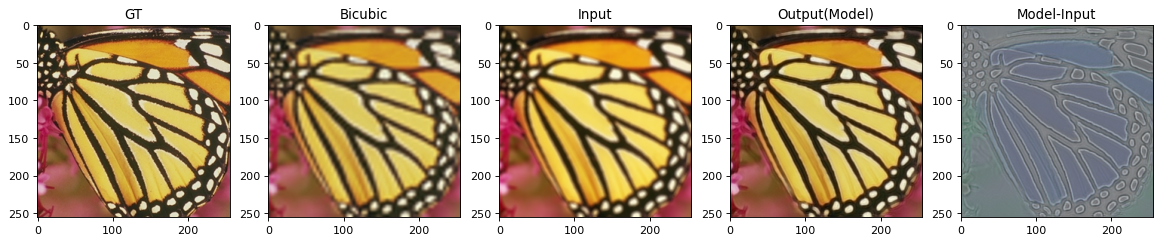

In [56]:
display_PSNR(im_gt, im_b, im_b2, model, channels=1);


In [57]:
# Make this load still photos too, and have them added with frame = 0
def test_results(test_dir,scale, channels=1, display = False):
    instances = []
    psnr_bicubic_sum = 0
    psnr_model_sum = 0
    ct = 0
    
    for filename in listdir(test_dir):
        filepath = os.path.join(test_dir,filename)
        #print(filepath)
                
        if is_image_file(filepath):
            im_gt = Image.open(filepath).convert("RGB")
            #print(im_gt.size)
            
            (height, width) = im_gt.size
            im_b = im_gt.resize((int(height/scale), int(width/scale)), resample = Image.BICUBIC)
            im_b = im_b.resize((height,width), resample = Image.BICUBIC)
            im_b2 = pil_disk_blur(im_gt,scale*2)
            
            im_h, psnr_bicubic, psnr_predicted = display_PSNR(im_gt, im_b, im_b2, model, channels=channels, display = display)
            psnr_bicubic_sum = psnr_bicubic_sum + psnr_bicubic
            psnr_model_sum = psnr_model_sum + psnr_predicted
            ct = ct +1
            #item = {"Filepath":filepath, "Type":"image"}
            #instances.append(item)
        
    psnr_bicubic_avg = psnr_bicubic_sum / ct
    psnr_model_avg = psnr_model_sum / ct
        
    print("Bicubic average PSNR =",psnr_bicubic_avg)
    print("Model average PSNR =",psnr_model_avg)
    return 



psnr for bicubic is 33.390163695766894dB
psnr for input is 32.79310964459529dB
psnr for Model is 28.355783742050903dB
PSNR improvement is -4.437325902544387dB
Sharpness Measurement GroundTruth: 247.28295878820063
Sharpness Measurement Bicubic: 9.535258178118966
Sharpness Measurement Input: 5.858893811702728
Sharpness Measurement Model: 46.639382403111085


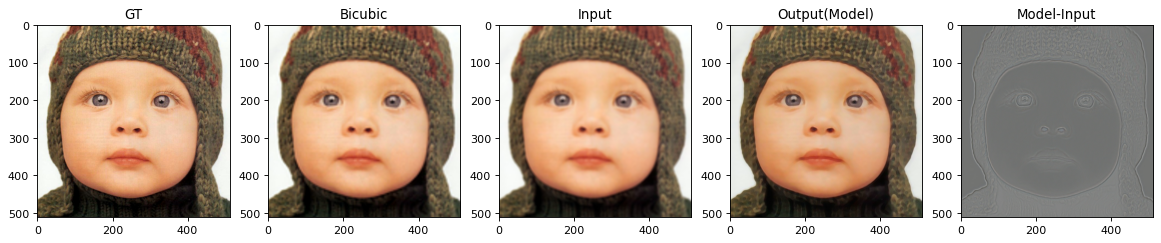

psnr for bicubic is 32.235298592507704dB
psnr for input is 31.382772027682307dB
psnr for Model is 29.76561238158248dB
PSNR improvement is -1.6171596460998288dB
Sharpness Measurement GroundTruth: 726.1960912189749
Sharpness Measurement Bicubic: 24.910532272341808
Sharpness Measurement Input: 14.338576666300607
Sharpness Measurement Model: 125.40839551610352


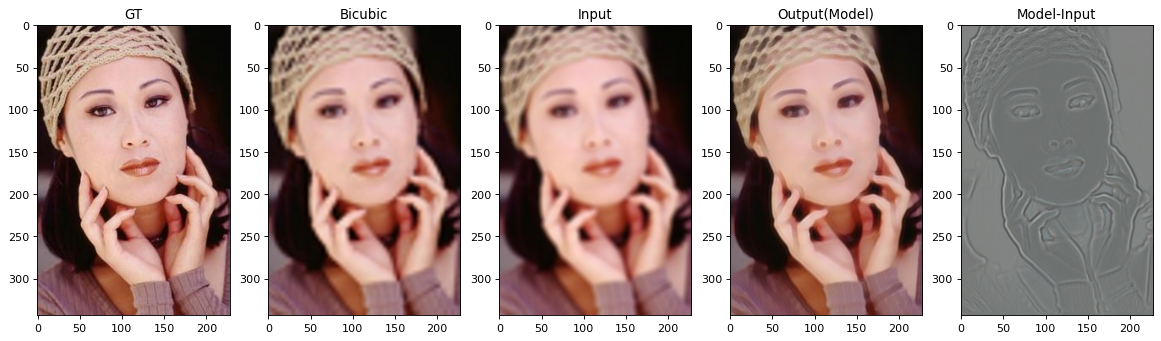

psnr for bicubic is 30.211868582917297dB
psnr for input is 28.432968257934547dB
psnr for Model is 29.5822956343728dB
PSNR improvement is 1.1493273764382543dB
Sharpness Measurement GroundTruth: 2236.2222292274237
Sharpness Measurement Bicubic: 68.43807946145535
Sharpness Measurement Input: 54.08266585692763
Sharpness Measurement Model: 411.1332745475229


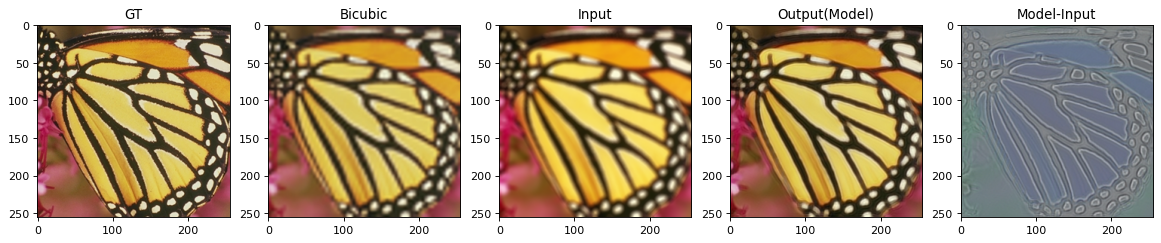

psnr for bicubic is 31.72207407894435dB
psnr for input is 31.14274836086718dB
psnr for Model is 30.550488234587185dB
PSNR improvement is -0.5922601262799958dB
Sharpness Measurement GroundTruth: 593.2631865654935
Sharpness Measurement Bicubic: 5.852487158833559
Sharpness Measurement Input: 5.359579077565338
Sharpness Measurement Model: 25.590359745939192


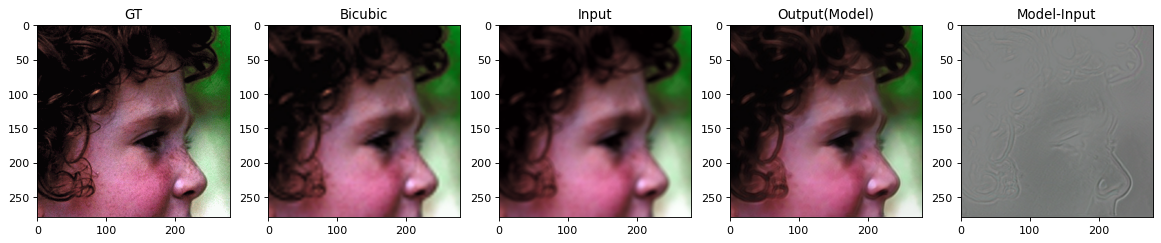

psnr for bicubic is 32.67973093611556dB
psnr for input is 31.727980012822368dB
psnr for Model is 31.560649831491542dB
PSNR improvement is -0.16733018133082567dB
Sharpness Measurement GroundTruth: 233.21159694144288
Sharpness Measurement Bicubic: 15.434929803238646
Sharpness Measurement Input: 8.727089964313272
Sharpness Measurement Model: 73.00670629477214


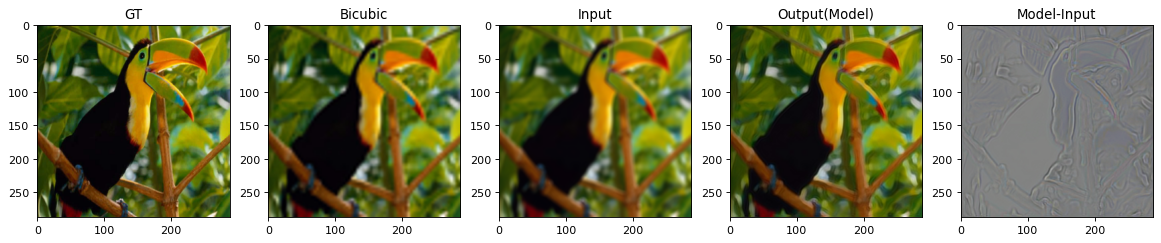

Bicubic average PSNR = 32.04782717725036
Model average PSNR = 29.96296596481698


In [58]:
test_results("/media/SSD/superres/video_data/test_data/Set5", 4, channels = 1,display = True)

In [ ]:
test_results("/media/SSD/superres/video_data/test_data/Set5", 4, channels = 1,display = True)

# convert sample videos

In [59]:
result_path

PosixPath('/media/SSD/superres/Results/Superresolution train New Network Div2 training')

In [60]:


infile = "/media/SSD/superres/muffins30sec.mp4"
outfile = result_path/"muffins30sec-16.mp4"
superres_mp4(infile, outfile, model,channels=1, factor=1.6,display=False,bitrate= "4000k")

  0%|          | 2/900 [00:00<01:06, 13.54it/s]

Original File: /media/SSD/superres/muffins30sec.mp4
frames= 900 
width= 320 
height= 240 
fps= 30.0

Process File: /media/SSD/superres/Results/Superresolution train New Network Div2 training/muffins30sec-16.mp4
factor: 1.6 
width= 512 
height= 384 
bitrate= 4000k


100%|██████████| 900/900 [01:07<00:00, 13.42it/s]


True

In [61]:
infile = "/media/SSD/superres/muffins30sec.mp4"
outfile = result_path/"muffins30sec-10.mp4"
superres_mp4(infile, outfile, model,channels=1, factor=1.0,display=False,bitrate= "4000k")

  2%|▏         | 18/900 [00:00<00:05, 173.47it/s]

Original File: /media/SSD/superres/muffins30sec.mp4
frames= 900 
width= 320 
height= 240 
fps= 30.0

Process File: /media/SSD/superres/Results/Superresolution train New Network Div2 training/muffins30sec-10.mp4
factor: 1.0 
width= 320 
height= 240 
bitrate= 4000k


100%|██████████| 900/900 [00:04<00:00, 220.39it/s]


True

In [62]:
infile = "/media/SSD/superres/muffins30sec.mp4"
outfile = result_path/"muffins30sec-20.mp4"
superres_mp4(infile, outfile, model,channels=1, factor=2.0,display=False,bitrate= "4000k")

  0%|          | 2/900 [00:00<00:58, 15.28it/s]

Original File: /media/SSD/superres/muffins30sec.mp4
frames= 900 
width= 320 
height= 240 
fps= 30.0

Process File: /media/SSD/superres/Results/Superresolution train New Network Div2 training/muffins30sec-20.mp4
factor: 2.0 
width= 640 
height= 480 
bitrate= 4000k


100%|██████████| 900/900 [01:10<00:00, 12.82it/s]


True

In [63]:
infile = "/media/SSD/superres/muffins30sec.mp4"
outfile = result_path/"muffins30sec-30.mp4"
superres_mp4(infile, outfile, model,channels=1, factor=3.0,display=False,bitrate= "4000k")


  0%|          | 0/900 [00:00<?, ?it/s]

Original File: /media/SSD/superres/muffins30sec.mp4
frames= 900 
width= 320 
height= 240 
fps= 30.0

Process File: /media/SSD/superres/Results/Superresolution train New Network Div2 training/muffins30sec-30.mp4
factor: 3.0 
width= 960 
height= 720 
bitrate= 4000k


100%|██████████| 900/900 [01:25<00:00, 10.49it/s]


True

In [64]:
dualfile= str(result_path/"muffins30sec-30dual.mp4")
infile = str(infile)
outfile = str(outfile)

In [65]:
# double scale for video x3 2 min
!ffmpeg -i {'"'+infile+'"'} -i {'"'+outfile+'"'} -t 120 -filter_complex "[0:v] scale=iw*2:ih*2, pad=2*iw:ih [left]; [1:v] scale=iw/1.5:ih/1.5 [right]; [left][right] overlay=main_w/2:0" -b:v 4000k {'"'+dualfile+'"'}

ffmpeg version 4.3.1 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7.5.0 (crosstool-NG 1.24.0.131_87df0e6_dirty)
  configuration: --prefix=/media/SSD/conda_env/superres --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1596712246804/_build_env/bin/x86_64-conda-linux-gnu-cc --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-gpl --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-libx264 --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame
  libavutil      56. 51.100 / 56. 51.100
  libavcodec     58. 91.100 / 58. 91.100
  libavformat    58. 45.100 / 58. 45.100
  libavdevice    58. 10.100 / 58. 10.100
  libavfilter     7. 85.100 /  7. 85.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  7.100 /  5.  7.100
  libswresample   3.  7.100 /  3.  7.100
  libpostproc    55.  7.100 / 55.  7.100
Input #0, mov,mp4,m4a,3gp,3g2,mj2, from '/media/SSD/su

In [66]:
# original scale , for video x3
#!ffmpeg -i {'"'+infile+'"'} -i {'"'+outfile+'"'} -filter_complex "[0:v] scale=iw*1:ih*1, pad=2*iw:ih [left]; [1:v] scale=iw/3:ih/3 [right]; [left][right] overlay=main_w/2:0" -b:v 4000k {'"'+dualfile+'"'}

In [67]:
infile = "/media/SSD/superres/super8/super8_best_from_mp2.mp4"
outfile = result_path/"super8.mp4"
error_file = "/media/SSD/superres/error.txt"
superres_mp4(infile, outfile, model,channels=1, factor=1.0,display=False,bitrate= "4000k",errorfile = error_file)

Original File: /media/SSD/superres/super8/super8_best_from_mp2.mp4
frames= 7195 
width= 720 
height= 480 
fps= 59.94005994005994

Process File: /media/SSD/superres/Results/Superresolution train New Network Div2 training/super8.mp4
factor: 1.0 
width= 720 
height= 480 
bitrate= 4000k


100%|██████████| 7195/7195 [04:11<00:00, 28.58it/s]


True

In [68]:

dualfile = str(result_path/"super8dual.mp4")
infile = str(infile)
outfile = str(outfile)

In [69]:
# original scale , for film x1, removed un needed scaling
!ffmpeg -i {'"'+infile+'"'} -i {'"'+outfile+'"'} -filter_complex "[0:v]  pad=2*iw:ih [left];  [left][1:v] overlay=main_w/2:0" -b:v 4000k {'"'+dualfile+'"'}

ffmpeg version 4.3.1 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7.5.0 (crosstool-NG 1.24.0.131_87df0e6_dirty)
  configuration: --prefix=/media/SSD/conda_env/superres --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1596712246804/_build_env/bin/x86_64-conda-linux-gnu-cc --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-gpl --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-libx264 --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame
  libavutil      56. 51.100 / 56. 51.100
  libavcodec     58. 91.100 / 58. 91.100
  libavformat    58. 45.100 / 58. 45.100
  libavdevice    58. 10.100 / 58. 10.100
  libavfilter     7. 85.100 /  7. 85.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  7.100 /  5.  7.100
  libswresample   3.  7.100 /  3.  7.100
  libpostproc    55.  7.100 / 55.  7.100
Input #0, mov,mp4,m4a,3gp,3g2,mj2, from '/media/SSD/su

In [70]:
# compare this model to the last one
infile = "/media/SSD/superres/Results/Superresolution train vdsr with hres perception loss multifuz/super8hresperfuzmodel2.mp4"
outfile = str(result_path/"super8.mp4")
dualfile= str(result_path/"super8-tolast-dual.mp4")

In [71]:
# original scale , for film x1, removed un needed scaling
!ffmpeg -i {'"'+infile+'"'} -i {'"'+outfile+'"'} -filter_complex "[0:v]  pad=2*iw:ih [left];  [left][1:v] overlay=main_w/2:0" -b:v 4000k {'"'+dualfile+'"'}

ffmpeg version 4.3.1 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7.5.0 (crosstool-NG 1.24.0.131_87df0e6_dirty)
  configuration: --prefix=/media/SSD/conda_env/superres --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1596712246804/_build_env/bin/x86_64-conda-linux-gnu-cc --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-gpl --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-libx264 --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame
  libavutil      56. 51.100 / 56. 51.100
  libavcodec     58. 91.100 / 58. 91.100
  libavformat    58. 45.100 / 58. 45.100
  libavdevice    58. 10.100 / 58. 10.100
  libavfilter     7. 85.100 /  7. 85.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  7.100 /  5.  7.100
  libswresample   3.  7.100 /  3.  7.100
  libpostproc    55.  7.100 / 55.  7.100
Input #0, mov,mp4,m4a,3gp,3g2,mj2, from '/media/SSD/su

In [ ]:
infile = "/media/SSD/superres/super8/Old 8mm Reels_1.mp4"
outfile = str(result_path/"super8long.mp4")
error_file = "/media/SSD/superres/error.txt"
superres_mp4(infile, outfile, model,channels=1, factor=1.0,display=False,bitrate= "4000k",errorfile = error_file)

In [ ]:
dualfile= str(result_path/"super8longdual.mp4")
infile = str(infile)
outfile = str(outfile)

In [ ]:
# original scale , for film x1, removed un needed scaling
!ffmpeg -i {'"'+infile+'"'} -i {'"'+outfile+'"'} -filter_complex "[0:v]  pad=2*iw:ih [left];  [left][1:v] overlay=main_w/2:0" -b:v 4000k {'"'+dualfile+'"'}